# EDA on Youtube

**Objective :**

Analizing the data to get insights into YouTube trending videos, to see what is common between these videos. 
Alse analizing some common factors :

1. How many views do our trending videos have? Do most of them have a large number of views? Is having a large number of views required for a video to become trending?
2. The same questions above, but applied to likes and comment count instead of views.
3. Which video remained the most on the trendin-videos list?
4. How many trending videos contain a fully-capitalized word in their titles?
5. What are the lengths of trending video titles? Is this length related to the video becoming trendy?
6. How are views, likes, dislikes, comment count, title length, and other attributes correlate with (relate to) each other? How are they connected?
7. What are the most common words in trending video titles?
8. Which YouTube channels have the largest number of trending videos?
9. Which video category (e.g. Entertainment, Gaming, Comedy, etc.) has the largest number of trending videos?
10. When were trending videos published? On which days of the week? at which times of the day?

**Data Source :**

YouTube  maintains a list of the top trending videos on the platform. 
“
To determine the year’s top-trending videos, YouTube uses a combination of factors including measuring users interactions (number of views, shares, comments and likes). This dataset is a daily record of the top trending YouTube videos.

The data used in this analysis was retrieved using YouTube API. 

**Work Flow :**

1. Data Extraction
2. Corelations between dataset variables
3. conclusion

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
from collections import Counter
import datetime
import wordcloud
import json

In [2]:
# Hiding warnings for cleaner display
warnings.filterwarnings('ignore')

# Configuring some options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# If you want interactive plots, uncomment the next line
# %matplotlib notebook

# 1. Data Extraction

In [3]:
df = pd.read_csv("../input/USvideos.csv")

In [4]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='Arial', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

In [5]:
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


Now, let's see some information about our dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
video_id                  40949 non-null object
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(8)
memory usage: 4.2+ MB


**Data Cleaning**

In [7]:
df[df["description"].apply(lambda x: pd.isna(x))].head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
42,NZFhMSgbKKM,17.14.11,Dennis Smith Jr. and LeBron James go back and ...,Ben Rohrbach,17,2017-11-13T15:11:00.000Z,[none],945,7,5,8,https://i.ytimg.com/vi/NZFhMSgbKKM/default.jpg,False,False,False,NaN
47,sbcbvuitiTc,17.14.11,Stephon Marbury and Jimmer Fredette fight in C...,NBA Highlights · YouTube,17,2017-11-10T18:23:05.000Z,"NBA|""Basketball""|""Sports""",956169,2017,2425,1447,https://i.ytimg.com/vi/sbcbvuitiTc/default.jpg,False,False,False,NaN
175,4d07RXYLsJE,17.14.11,Sphaera - demonstrating interaction,Jenny Hanell,28,2017-11-04T20:48:16.000Z,[none],1827,3,0,2,https://i.ytimg.com/vi/4d07RXYLsJE/default.jpg,False,False,False,NaN


So to do some sort of data cleaning, and to get rid of those null values, we put an empty string in place of each null value in the `description` column

In [8]:
df["description"] = df["description"].fillna(value="")

## <a name="coll"></a>Dataset collection years
Let's see in which years the dataset was collected

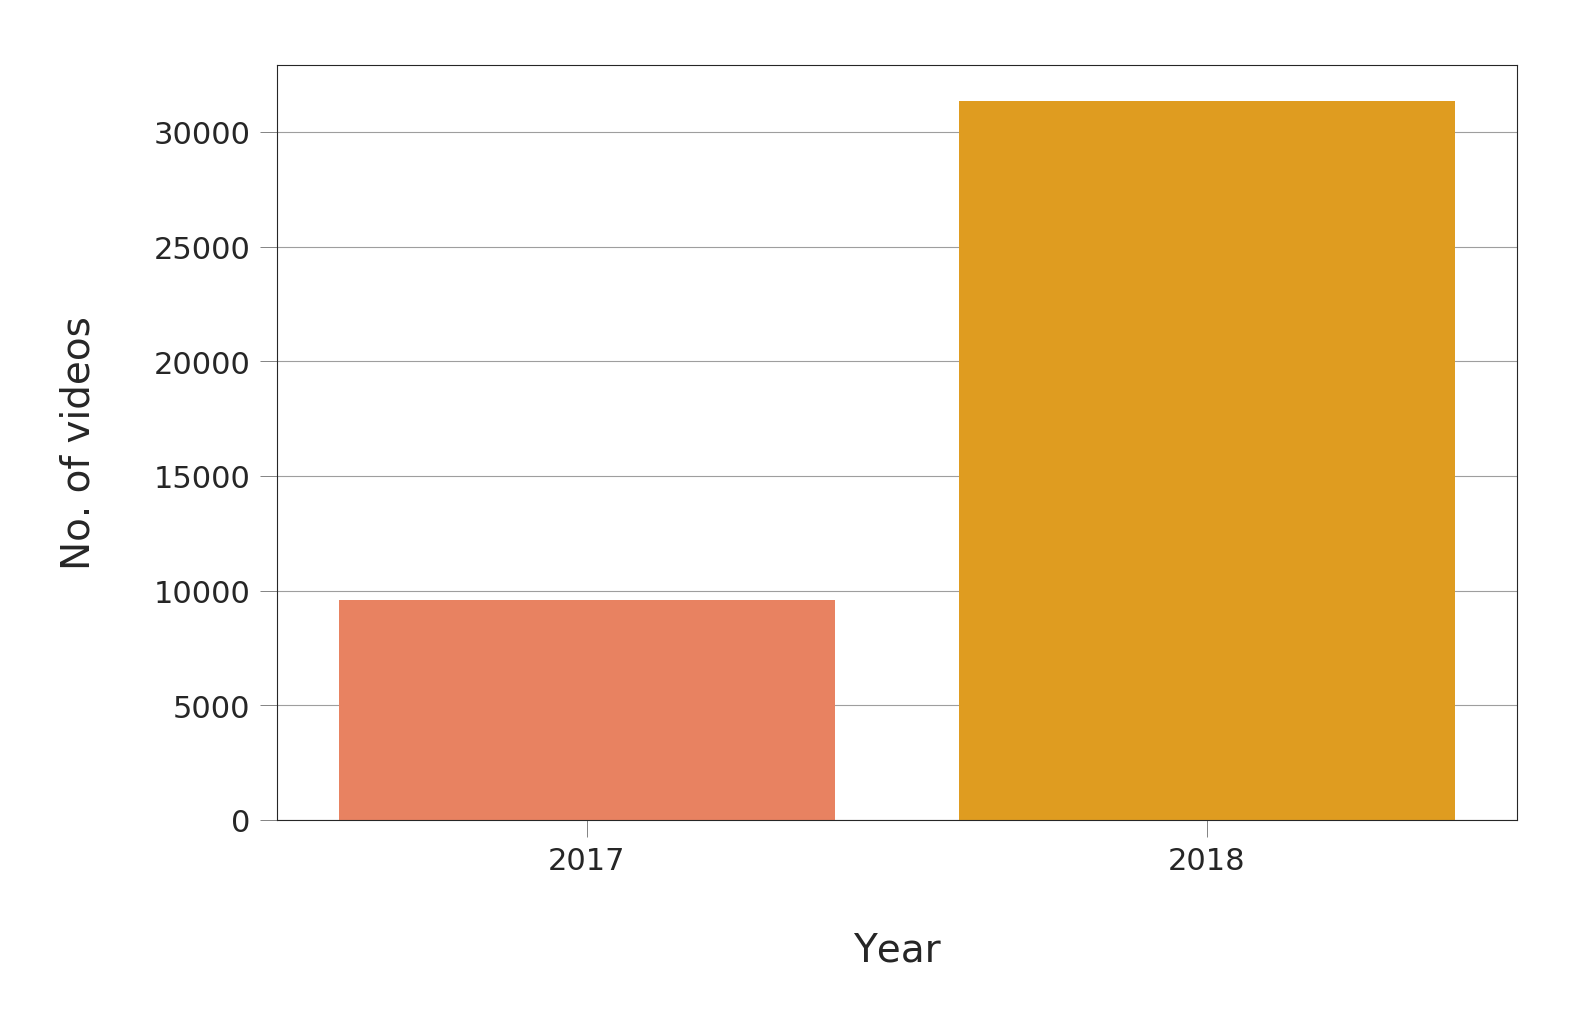

In [9]:
cdf = df["trending_date"].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={"index": "year", "trending_date": "No_of_videos"})

fig, ax = plt.subplots()
_ = sns.barplot(x="year", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos")

In [10]:
df["trending_date"].apply(lambda x: '20' + x[:2]).value_counts(normalize=True)

2018   0.77
2017   0.23
Name: trending_date, dtype: float64

We can see that the dataset was collected in 2017 and 2018 with `77%` of it in 2018 and `23%` in 2017.

## <a name="descn"></a>Describtion of numerical columns
Now, let's see some statistical information about the numerical columns of our dataset

In [11]:
df.describe()

,category_id,views,likes,dislikes,comment_count
count,40949.00,40949.00,40949.00,40949.00,40949.00
mean,19.97,2360784.64,74266.70,3711.40,8446.80
std,7.57,7394113.76,228885.34,29029.71,37430.49
min,1.00,549.00,0.00,0.00,0.00
25%,17.00,242329.00,5424.00,202.00,614.00
50%,24.00,681861.00,18091.00,631.00,1856.00
75%,25.00,1823157.00,55417.00,1938.00,5755.00
max,43.00,225211923.00,5613827.00,1674420.00,1361580.00


We note from the table above that 
- The average number of views of a trending video is `2,360,784`. The median value for the number of views is `681,861`, which means that half the trending videos have views that are less than that number, and the other half have views larger than that number
- The average number of likes of a trending video is `74,266`, while the average number of dislikes is `3,711`. The 
- Average comment count is `8,446` while the median is `1,856`

How useful are the observations above? Do they really represent the data? Let's examine more. 

### <a name="vh"></a>Views histogram
let's plot a [histogram](https://www.mathsisfun.com/data/histograms.html) for the `views` column to take a look at its distribution: to see how many videos have between `10` million and `20` million views, how many videos have between `20` million and `30` million views, and so on.

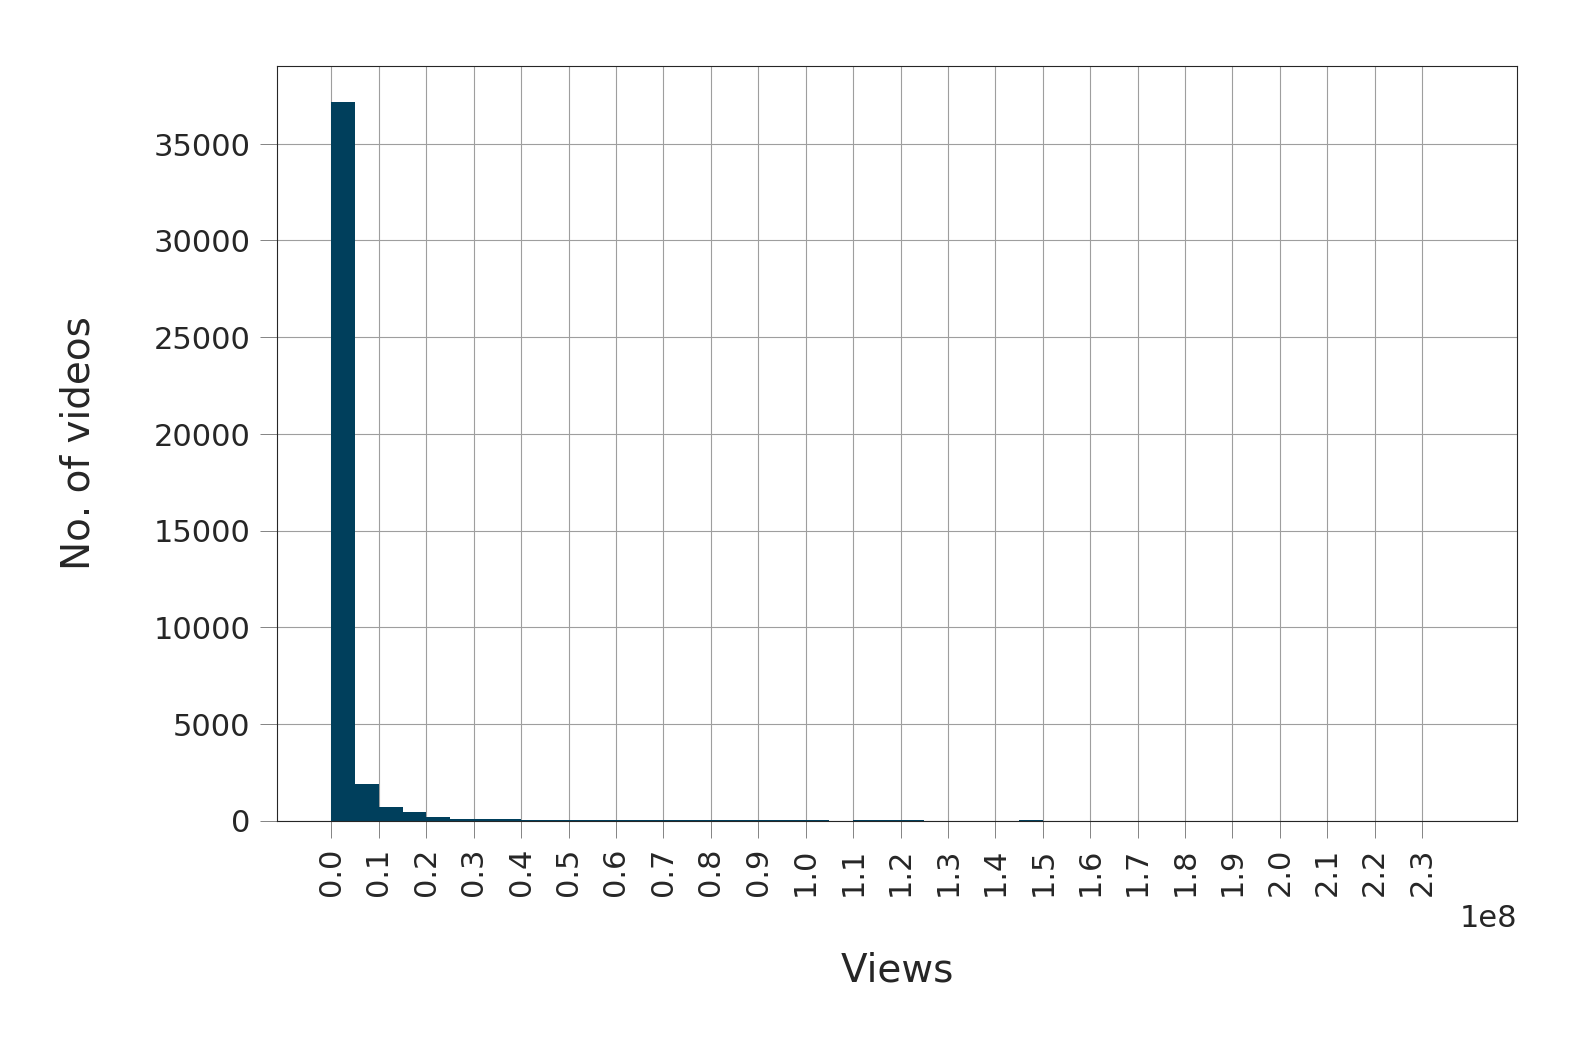

In [12]:
fig, ax = plt.subplots()
_ = sns.distplot(df["views"], kde=False, color=PLOT_COLORS[4], 
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.3e8, 47), ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos", xticks=np.arange(0, 2.4e8, 1e7))
_ = ax.set_xlim(right=2.5e8)
_ = plt.xticks(rotation=90)

We note that the vast majority of trending videos have `5` million views or less. We get the `5` million number by calculating

\begin{align}
\frac{0.1 \times 10^8}{2} = 5 \times 10^6
\end{align}

Now let us plot the histogram just for videos with `25` million views or less to get a closer look at the distribution of the data

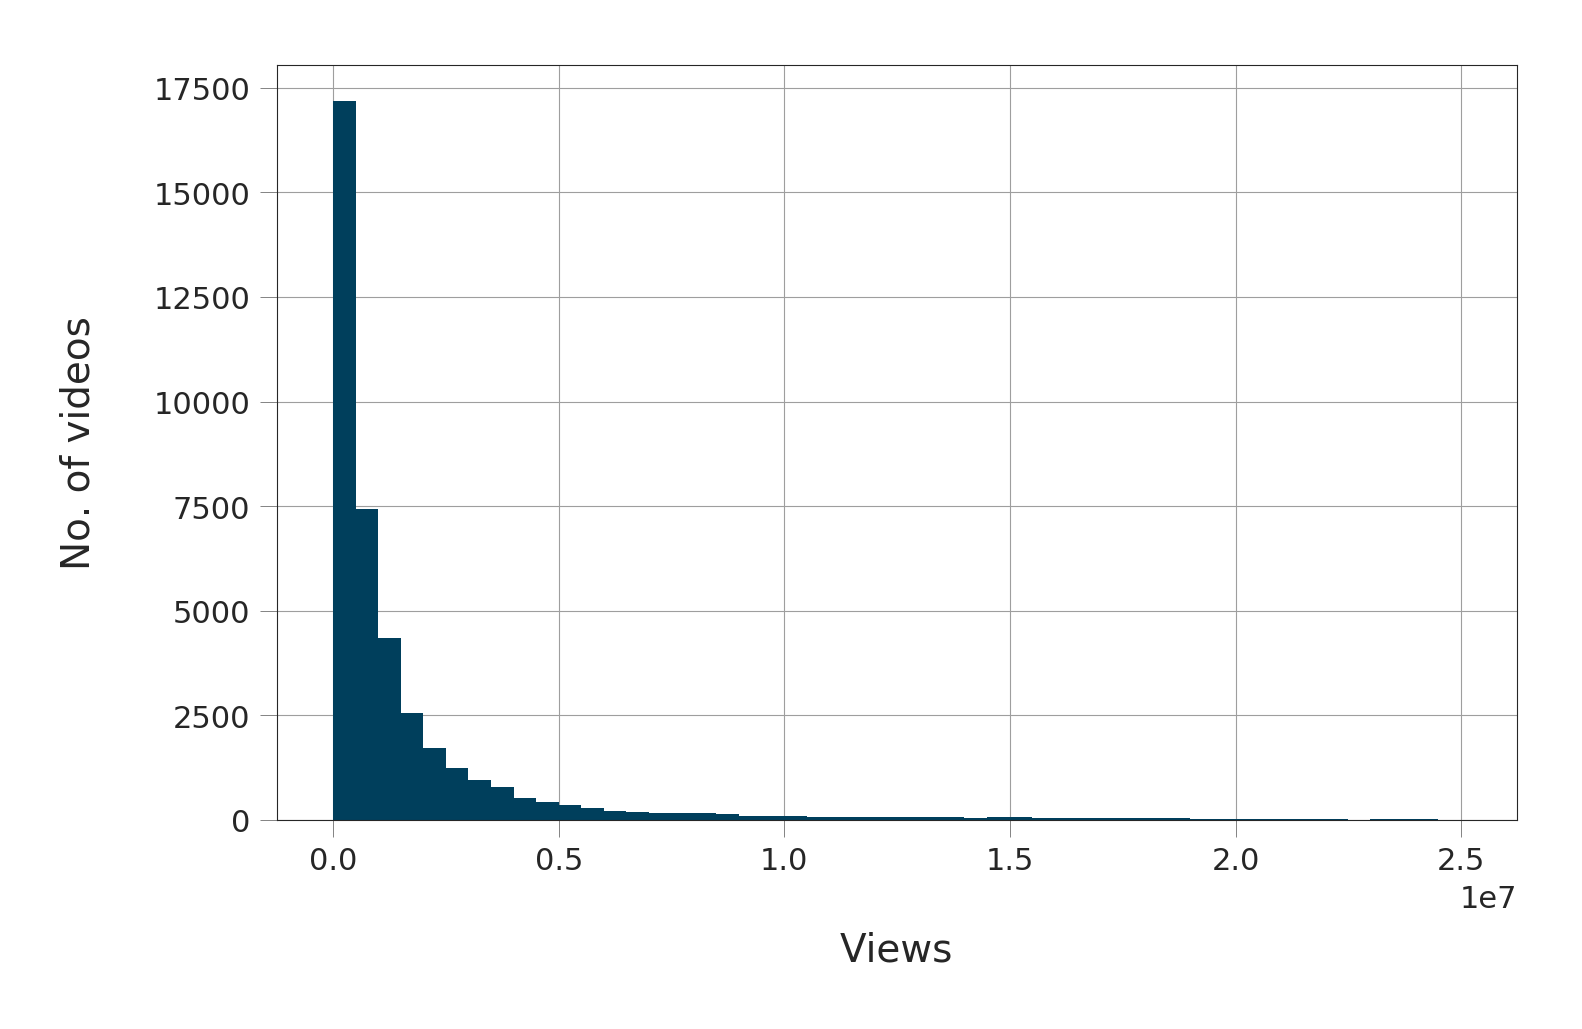

In [13]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["views"] < 25e6]["views"], kde=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Views", ylabel="No. of videos")

Now we see that the majority of trending videos have `1` million views or less. Let's see the exact percentage of videos less than `1` million views

In [14]:
df[df['views'] < 1e6]['views'].count() / df['views'].count() * 100

60.09426359618062

So, it is around `60%`. Similarly, we can see that the percentage of videos with less than `1.5` million views is around `71%`, and that the percentage of videos with less than `5` million views is around `91%`.

### <a name="lh"></a>Likes histogram

After `views`, we plot the histogram for `likes` column

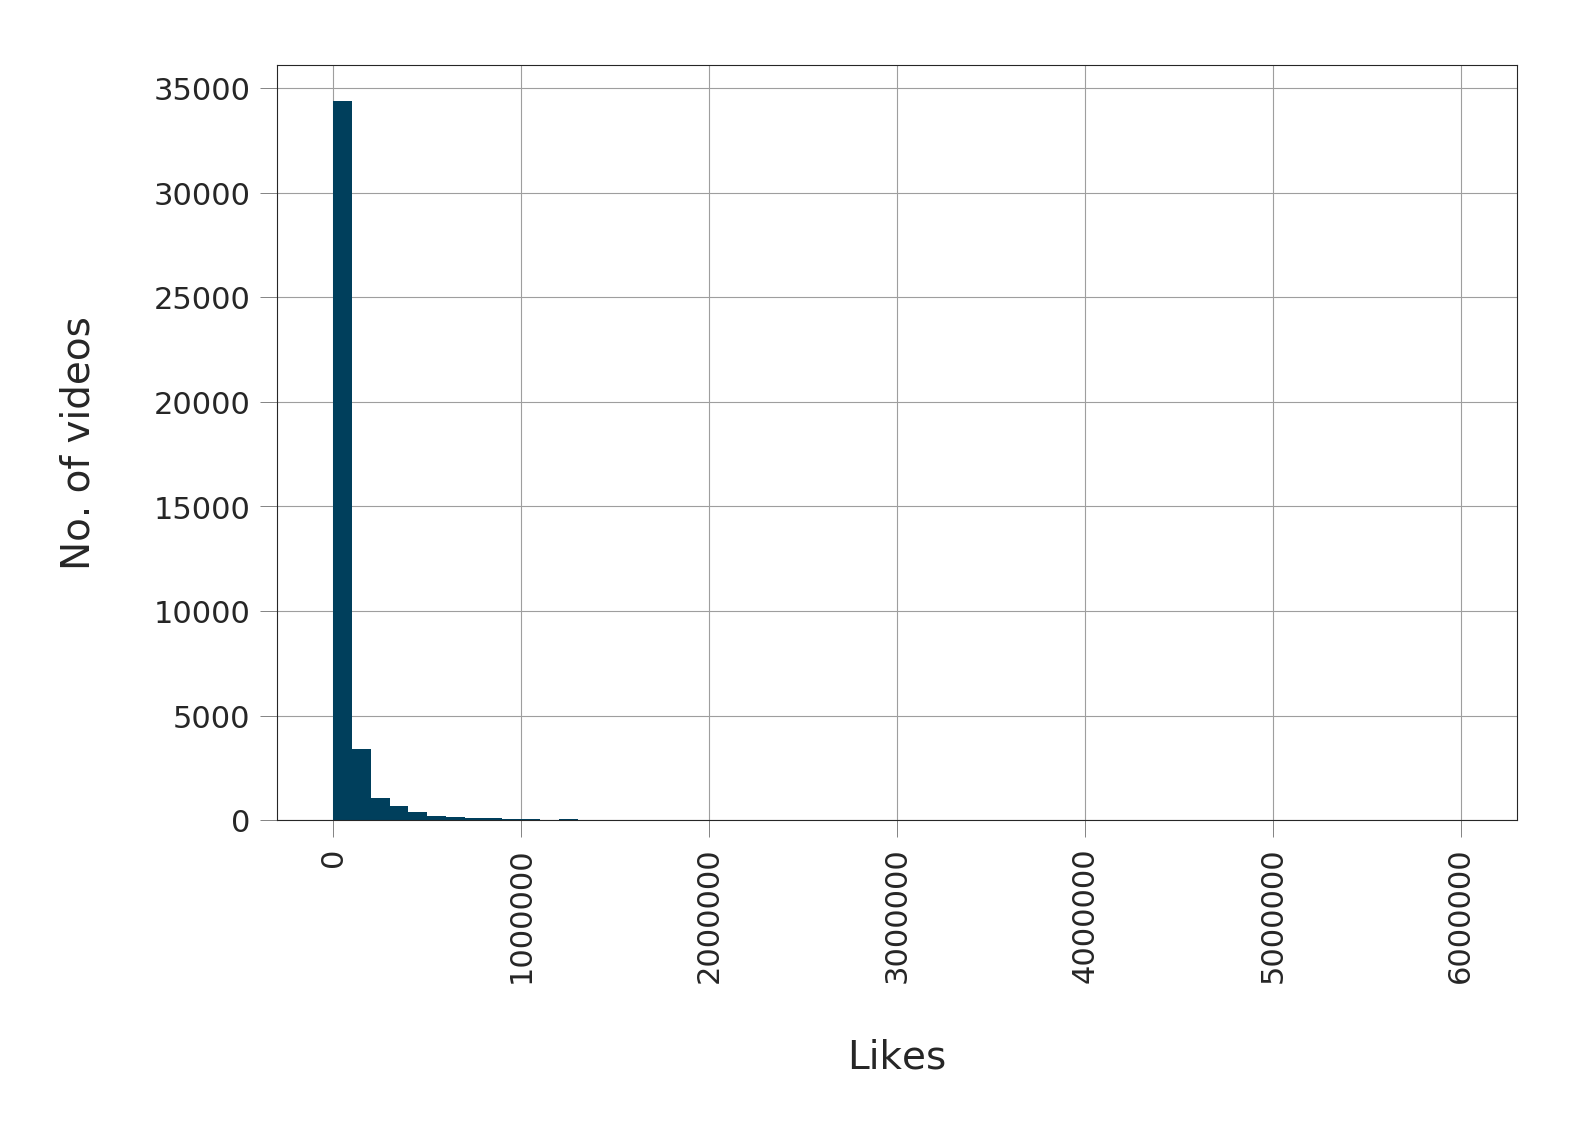

In [15]:
plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(df["likes"], kde=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 6e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")
_ = plt.xticks(rotation=90)

We note that the vast majority of trending videos have between `0` and `100,000` likes. Let us plot the histogram just for videos with `1000,000` likes or less to get a closer look at the distribution of the data

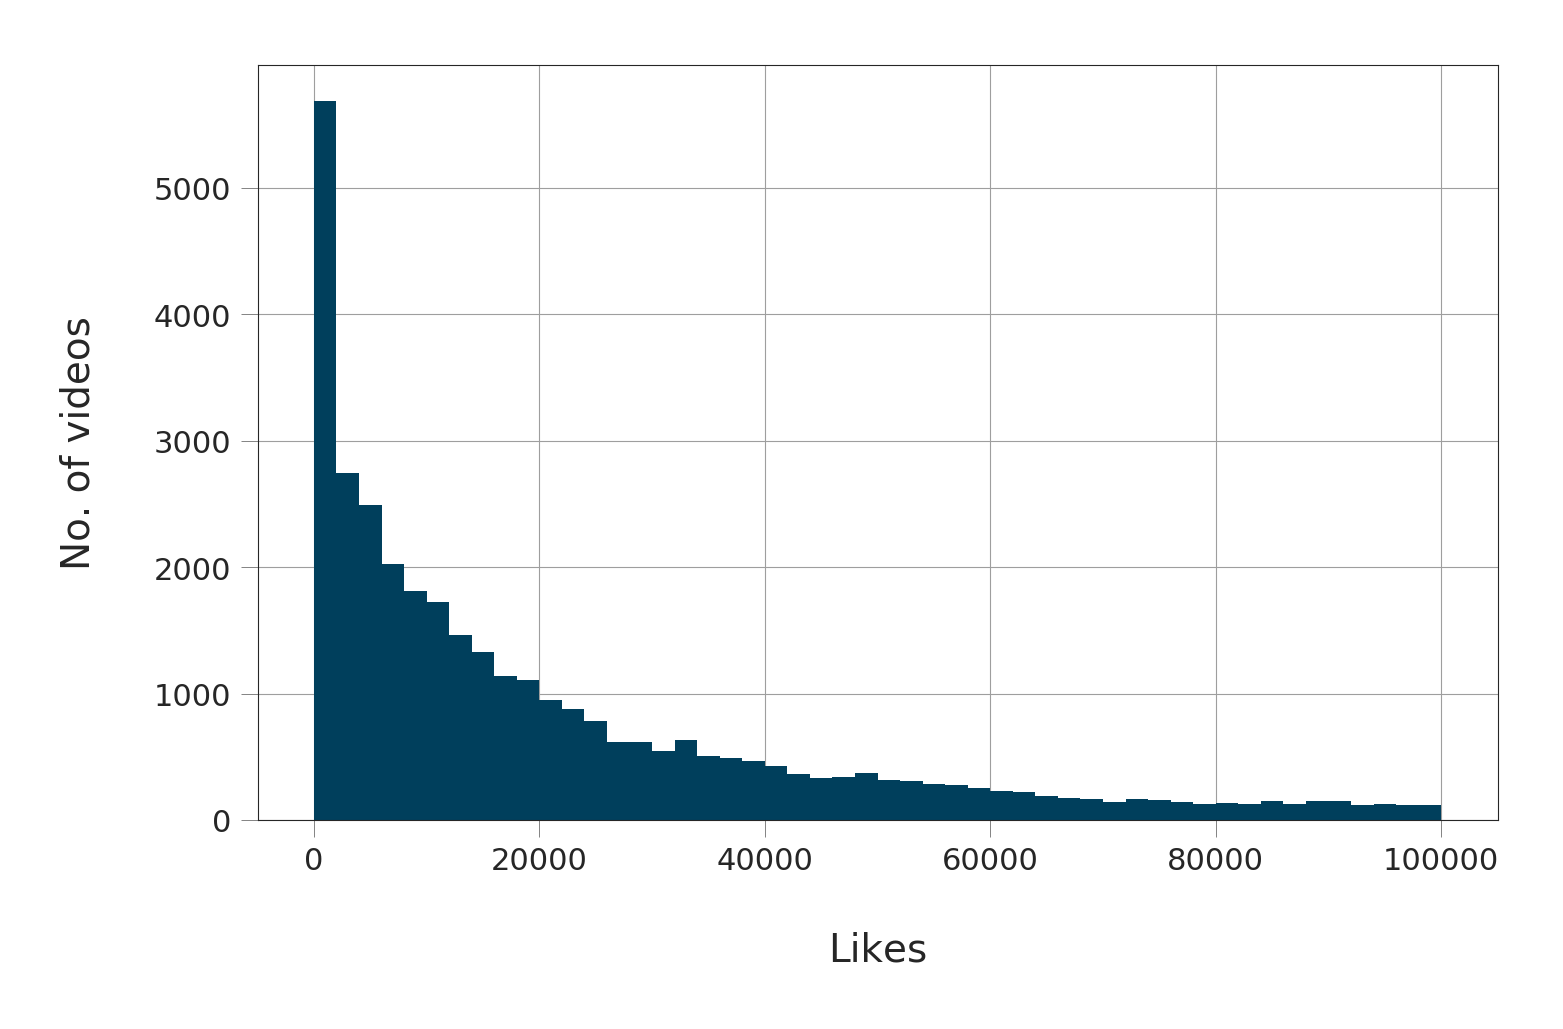

In [16]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["likes"] <= 1e5]["likes"], kde=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos")

Now we can see that the majority of trending videos have `40000` likes or less with a peak for videos with `2000` likes or less. 

Let's see the exact percentage of videos with less than `40000` likes 

In [17]:
df[df['likes'] < 4e4]['likes'].count() / df['likes'].count() * 100

68.4900730176561

Similarly, we can see that the percentage of videos with less than `100,000` likes is around `84%`

### <a name="ch"></a>Comment count histogram

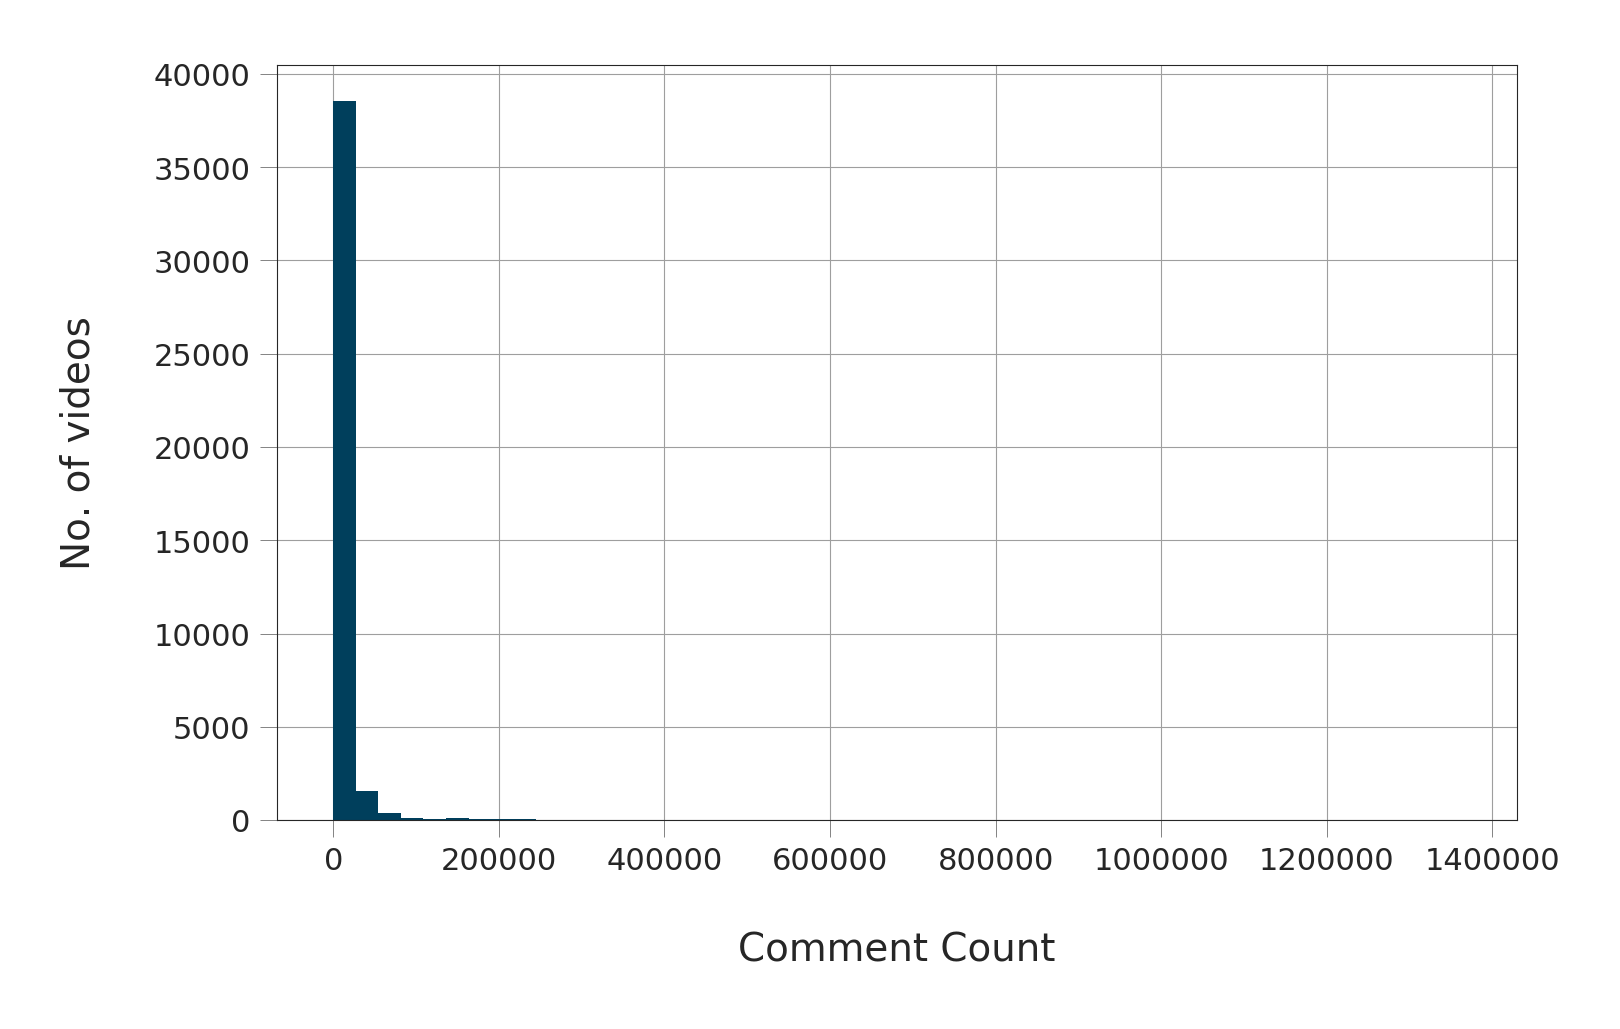

In [18]:
fig, ax = plt.subplots()
_ = sns.distplot(df["comment_count"], kde=False, rug=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos")

Let's get a closer look by eliminating entries with comment count larger than `200000` comment

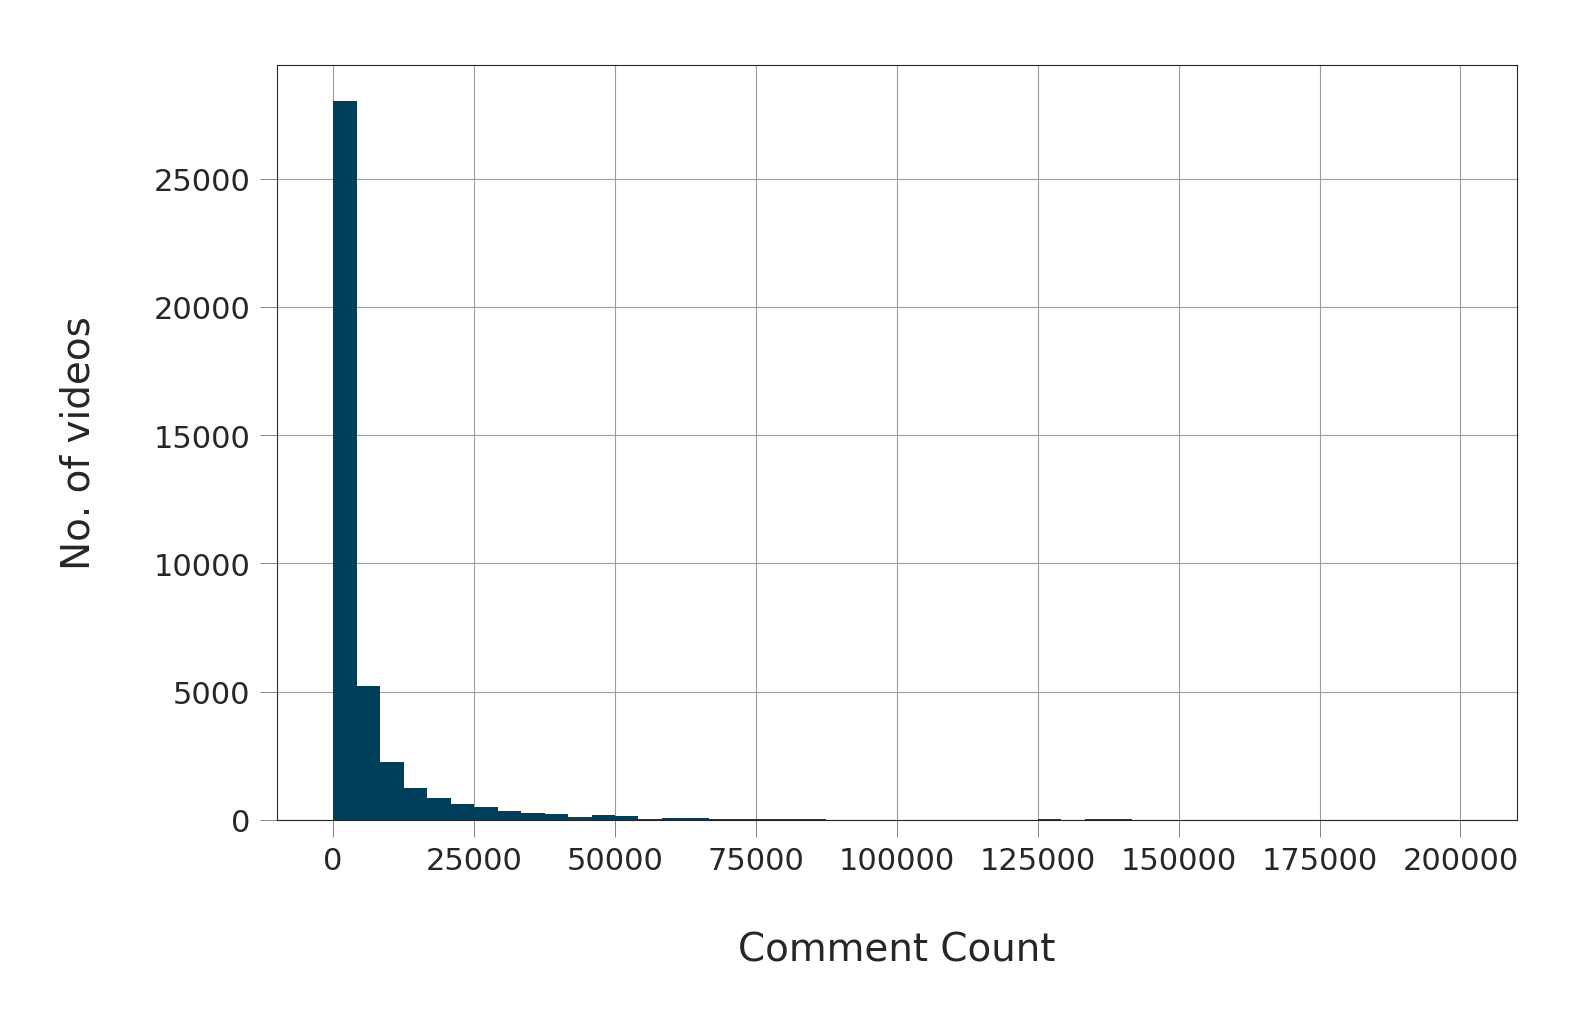

In [19]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["comment_count"] < 200000]["comment_count"], kde=False, rug=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 2e5, 49), ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos")

We see that most trending videos have around

\begin{align}
\frac{25000}{6} \approx 4166 \text{ comments}
\end{align}

since each division in the graph has six histogram bins. 

As with views and likes, let's see the exact percentage of videos with less than `4000` comments

In [20]:
df[df['comment_count'] < 4000]['comment_count'].count() / df['comment_count'].count() * 100

67.48882756599673

In a similar way, we can see that the percentage of videos with less than `25,000` comments  is around `93%`.

## <a name="descnn"></a>Description on non-numerical columns
After we described numerical columns previously, we now describe non-numerical columns

In [21]:
df.describe(include = ['O'])

,video_id,trending_date,title,channel_title,publish_time,tags,thumbnail_link,description
count,40949,40949,40949,40949,40949,40949,40949,40949
unique,6351,205,6455,2207,6269,6055,6352,6902
top,j4KvrAUjn6c,18.01.03,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,ESPN,2018-05-18T14:00:04.000Z,[none],https://i.ytimg.com/vi/j4KvrAUjn6c/default.jpg,
freq,30,200,30,203,50,1535,30,570


From the table above, we can see that there are `205` unique dates, which means that our dataset contains collected data about trending videos over **`205`** days.

From `video_id` description, we can see that there are `40949` videos (which is expected because our dataset contains `40949` entries), but we can see also that there are only `6351` unique videos which means that some videos appeared on the trending videos list **on more than one day**.
The table also tells us that the top frequent title is `WE MADE OUR MOM CRY...HER DREAM CAME TRUE!` and that it appeared `30` times on the trending videos list.

But there is something strange in the description table above: Because there are `6351` unique video IDs, we expect to have `6351` unique video titles also, because we assume that each ID is linked to a corresponding title. One possible interpretation is that a trending video had some title when it appeared on the trending list, then it appeared again on another day but with a modified title. Similar explaination applies for `description` column as well.
For `publish_time` column, the unique values are less than `6351`, but there is nothing strange here, because two different videos may be published at the same time.

To verify our interpretation for `title` column, let's take a look at an example where a trending video appeared more than once on the trending list but with different titles

In [22]:
grouped = df.groupby("video_id")
groups = []
wanted_groups = []
for key, item in grouped:
    groups.append(grouped.get_group(key))

for g in groups:
    if len(g['title'].unique()) != 1:
        wanted_groups.append(g)

wanted_groups[0]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
14266,0ufNmUyf2co,18.26.01,Here are the weirdest bikes I own - Freak Bike...,Seth's Bike Hacks,26,2018-01-25T00:00:04.000Z,"bikes|""bicycles""|""weird bikes""|""custom bikes""|...",183149,6969,68,824,https://i.ytimg.com/vi/0ufNmUyf2co/default.jpg,False,False,False,Some of the questions I get most are about my ...
14491,0ufNmUyf2co,18.27.01,Here are the weirdest bikes I own - Freak Bike...,Seth's Bike Hacks,26,2018-01-25T00:00:04.000Z,"bikes|""bicycles""|""weird bikes""|""custom bikes""|...",203919,7358,72,746,https://i.ytimg.com/vi/0ufNmUyf2co/default.jpg,False,False,False,Some of the questions I get most are about my ...
14706,0ufNmUyf2co,18.28.01,Bike Check - My freak bikes,Seth's Bike Hacks,26,2018-01-25T00:00:04.000Z,"bikes|""bicycles""|""weird bikes""|""custom bikes""|...",216447,7608,74,759,https://i.ytimg.com/vi/0ufNmUyf2co/default.jpg,False,False,False,Some of the questions I get most are about my ...
14931,0ufNmUyf2co,18.29.01,Bike Check - My freak bikes,Seth's Bike Hacks,26,2018-01-25T00:00:04.000Z,"bikes|""bicycles""|""weird bikes""|""custom bikes""|...",227005,7754,78,759,https://i.ytimg.com/vi/0ufNmUyf2co/default.jpg,False,False,False,Some of the questions I get most are about my ...
15175,0ufNmUyf2co,18.30.01,Bike Check - My freak bikes,Seth's Bike Hacks,26,2018-01-25T00:00:04.000Z,"bikes|""bicycles""|""weird bikes""|""custom bikes""|...",233482,7852,78,769,https://i.ytimg.com/vi/0ufNmUyf2co/default.jpg,False,False,False,Some of the questions I get most are about my ...
15385,0ufNmUyf2co,18.31.01,Bike Check - My freak bikes,Seth's Bike Hacks,26,2018-01-25T00:00:04.000Z,"bikes|""bicycles""|""weird bikes""|""custom bikes""|...",238483,7894,81,778,https://i.ytimg.com/vi/0ufNmUyf2co/default.jpg,False,False,False,Some of the questions I get most are about my ...


We can see that this video appeared on the list with two different titles.

## <a name="cap"></a>How many trending video titles contain capitalized word?
Now we want to see how many trending video titles contain at least a capitalized word (e.g. HOW). To do that, we will add a new variable (column) to the dataset whose value is `True` if the video title has at least a capitalized word in it, and `False` otherwise

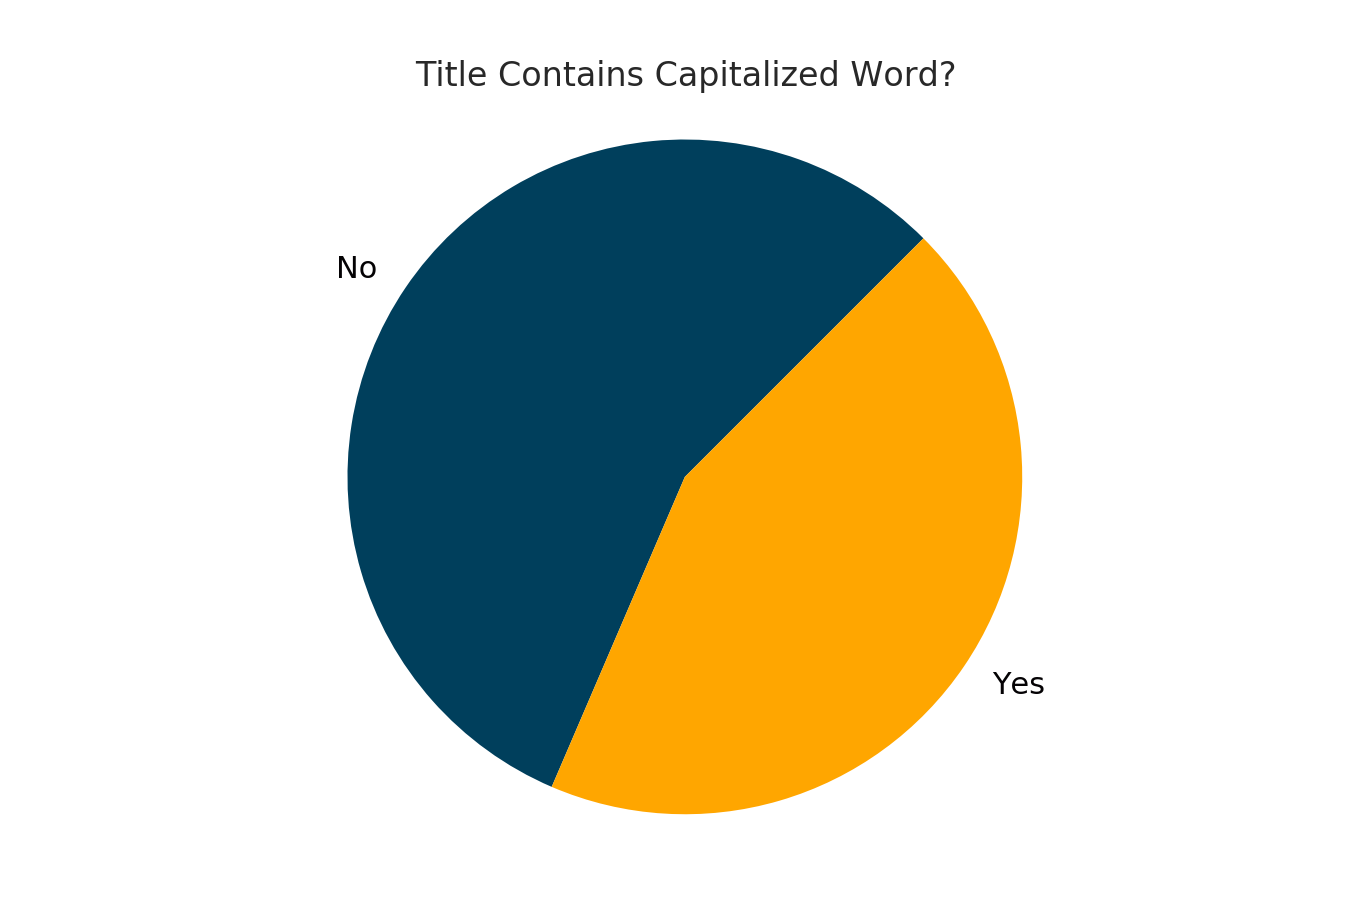

In [23]:
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False


df["contains_capitalized"] = df["title"].apply(contains_capitalized_word)

value_counts = df["contains_capitalized"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'}, startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Title Contains Capitalized Word?')

In [24]:
df["contains_capitalized"].value_counts(normalize=True)

False   0.56
True    0.44
Name: contains_capitalized, dtype: float64

We can see that 44% of trending video titles contain at least a capitalized word. We will later use this added new column `contains_capitalized` in analyzing correlation between variables.

## <a name="len"></a>Video title lengths
Let's add another column to our dataset to represent the length of each video title, then plot the histogram of title length to get an idea about the lengths of trnding video titles

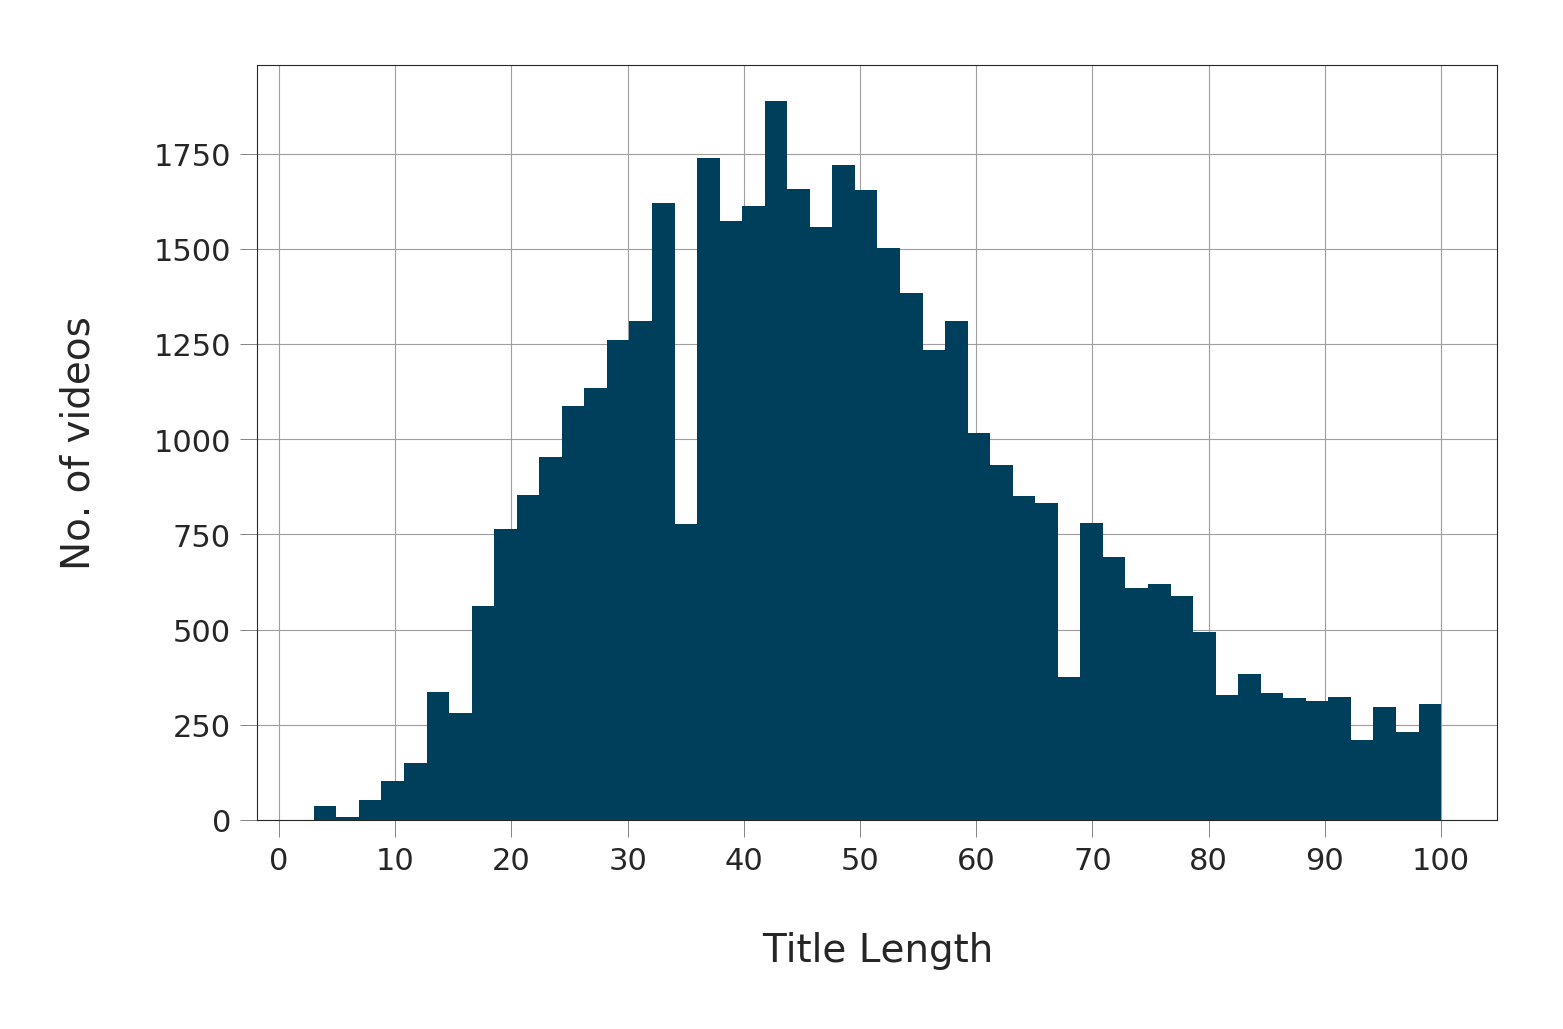

In [25]:
df["title_length"] = df["title"].apply(lambda x: len(x))

fig, ax = plt.subplots()
_ = sns.distplot(df["title_length"], kde=False, rug=False, 
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10))

We can see that title-length distribution resembles a normal distribution, where most videos have title lengths between 30 and 60 character approximately.

Now let's draw a [scatter plot](https://www.mathsisfun.com/data/scatter-xy-plots.html) between title length and number of views to see the relationship between these two variables

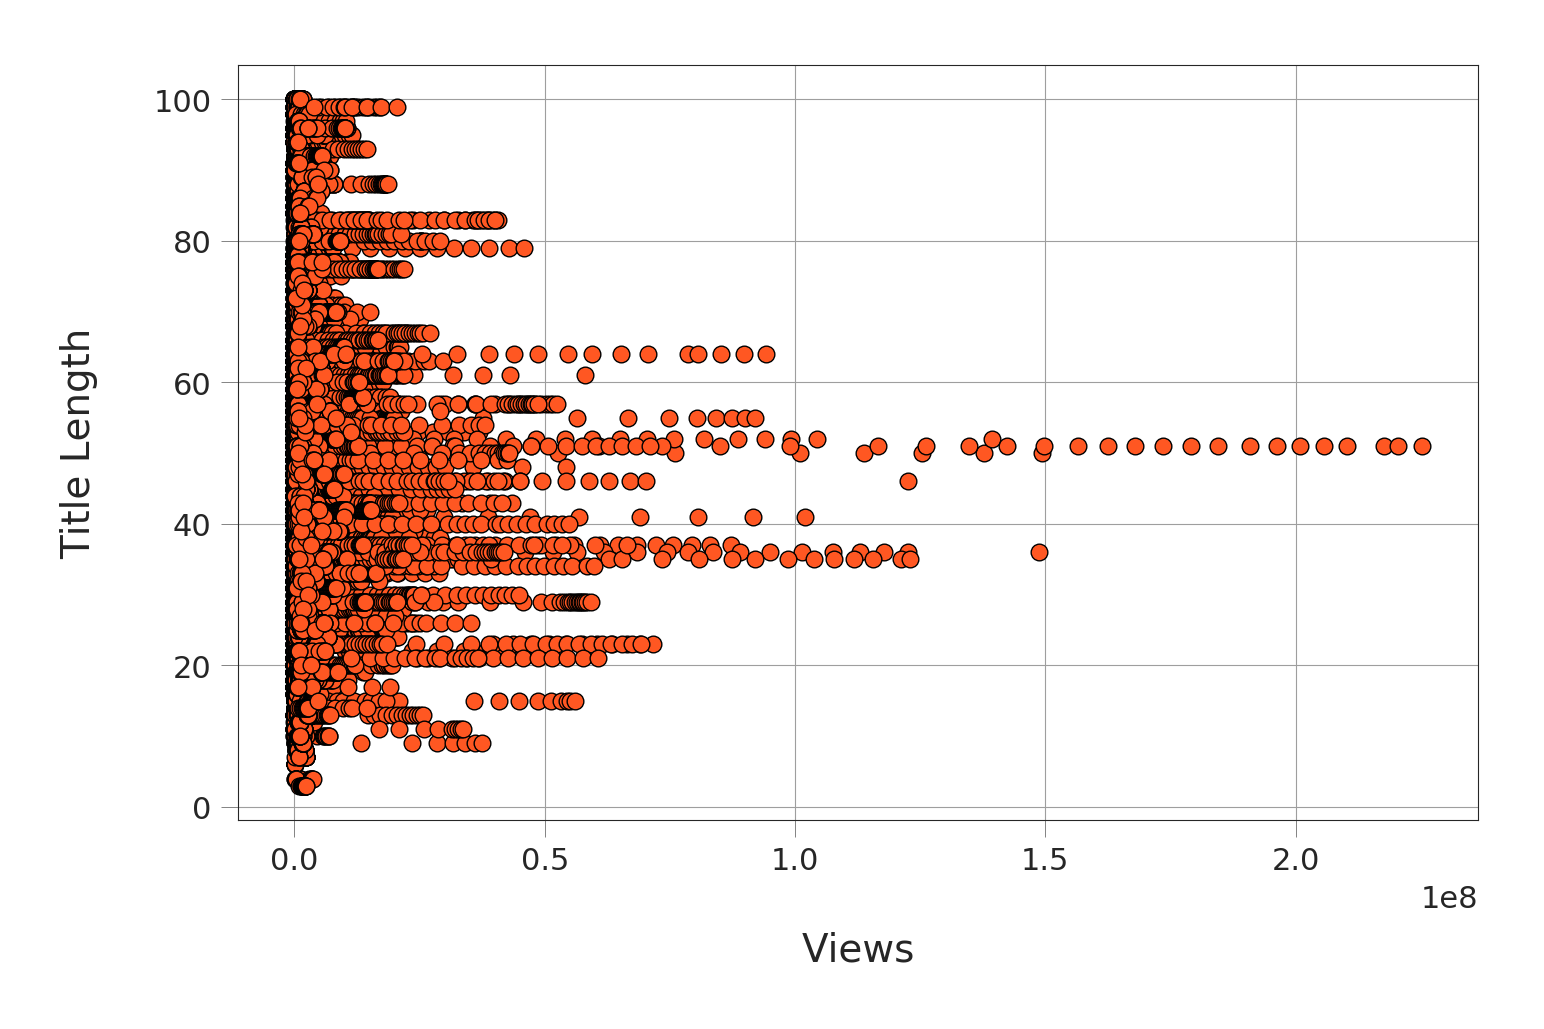

In [26]:
fig, ax = plt.subplots()
_ = ax.scatter(x=df['views'], y=df['title_length'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Title Length")

By looking at the scatter plot, we can say that there is no relationship between the title length and the number of views. However, we notice an interesting thing: videos that have `100,000,000` views and more have title length between `33` and `55` characters approximately.

# Correlation between dataset variables


Now let's see how the dataset variables are [correlated](https://www.mathsisfun.com/data/correlation.html) with each other: for example, we would like to see how views and likes are correlated, meaning do views and likes increase and decrease together (positive correlation)? Does one of them increase when the other decrease and vice versa (negative correlation)? Or are they not correlated?

Correlation is represented as a value between `-1` and `+1` where `+1` denotes the highest positive correlation, `-1` denotes the highest negative correlation, and `0` denotes that there is no correlation.

Let's see the correlation table between our dataset variables (numerical and boolean variables only)

In [27]:
df.corr()

,category_id,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,contains_capitalized,title_length
category_id,1.00,-0.17,-0.17,-0.03,-0.08,0.05,-0.01,-0.03,0.06,0.02
views,-0.17,1.00,0.85,0.47,0.62,0.00,0.02,-0.00,-0.03,-0.04
likes,-0.17,0.85,1.00,0.45,0.80,-0.03,-0.02,-0.00,-0.00,-0.08
dislikes,-0.03,0.47,0.45,1.00,0.70,-0.00,-0.01,-0.00,-0.02,-0.03
comment_count,-0.08,0.62,0.80,0.70,1.00,-0.03,-0.01,-0.00,0.02,-0.07
comments_disabled,0.05,0.00,-0.03,-0.00,-0.03,1.00,0.32,-0.00,0.01,0.03
ratings_disabled,-0.01,0.02,-0.02,-0.01,-0.01,0.32,1.00,-0.00,0.00,0.00
video_error_or_removed,-0.03,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,-0.02,-0.01
contains_capitalized,0.06,-0.03,-0.00,-0.02,0.02,0.01,0.00,-0.02,1.00,0.13
title_length,0.02,-0.04,-0.08,-0.03,-0.07,0.03,0.00,-0.01,0.13,1.00


We see for example that views and likes are highly positively correlated with a correlation value of `0.85`; we see also a high positive correlation (`0.80`) between likes and comment count, and between dislikes and comment count (`0.70`). 

There is some positive correlation between views and dislikes, between views and comment count, between likes and dislikes.

Now let's visualize the correlation table above using a [heatmap](https://www.wikiwand.com/en/Heat_map)

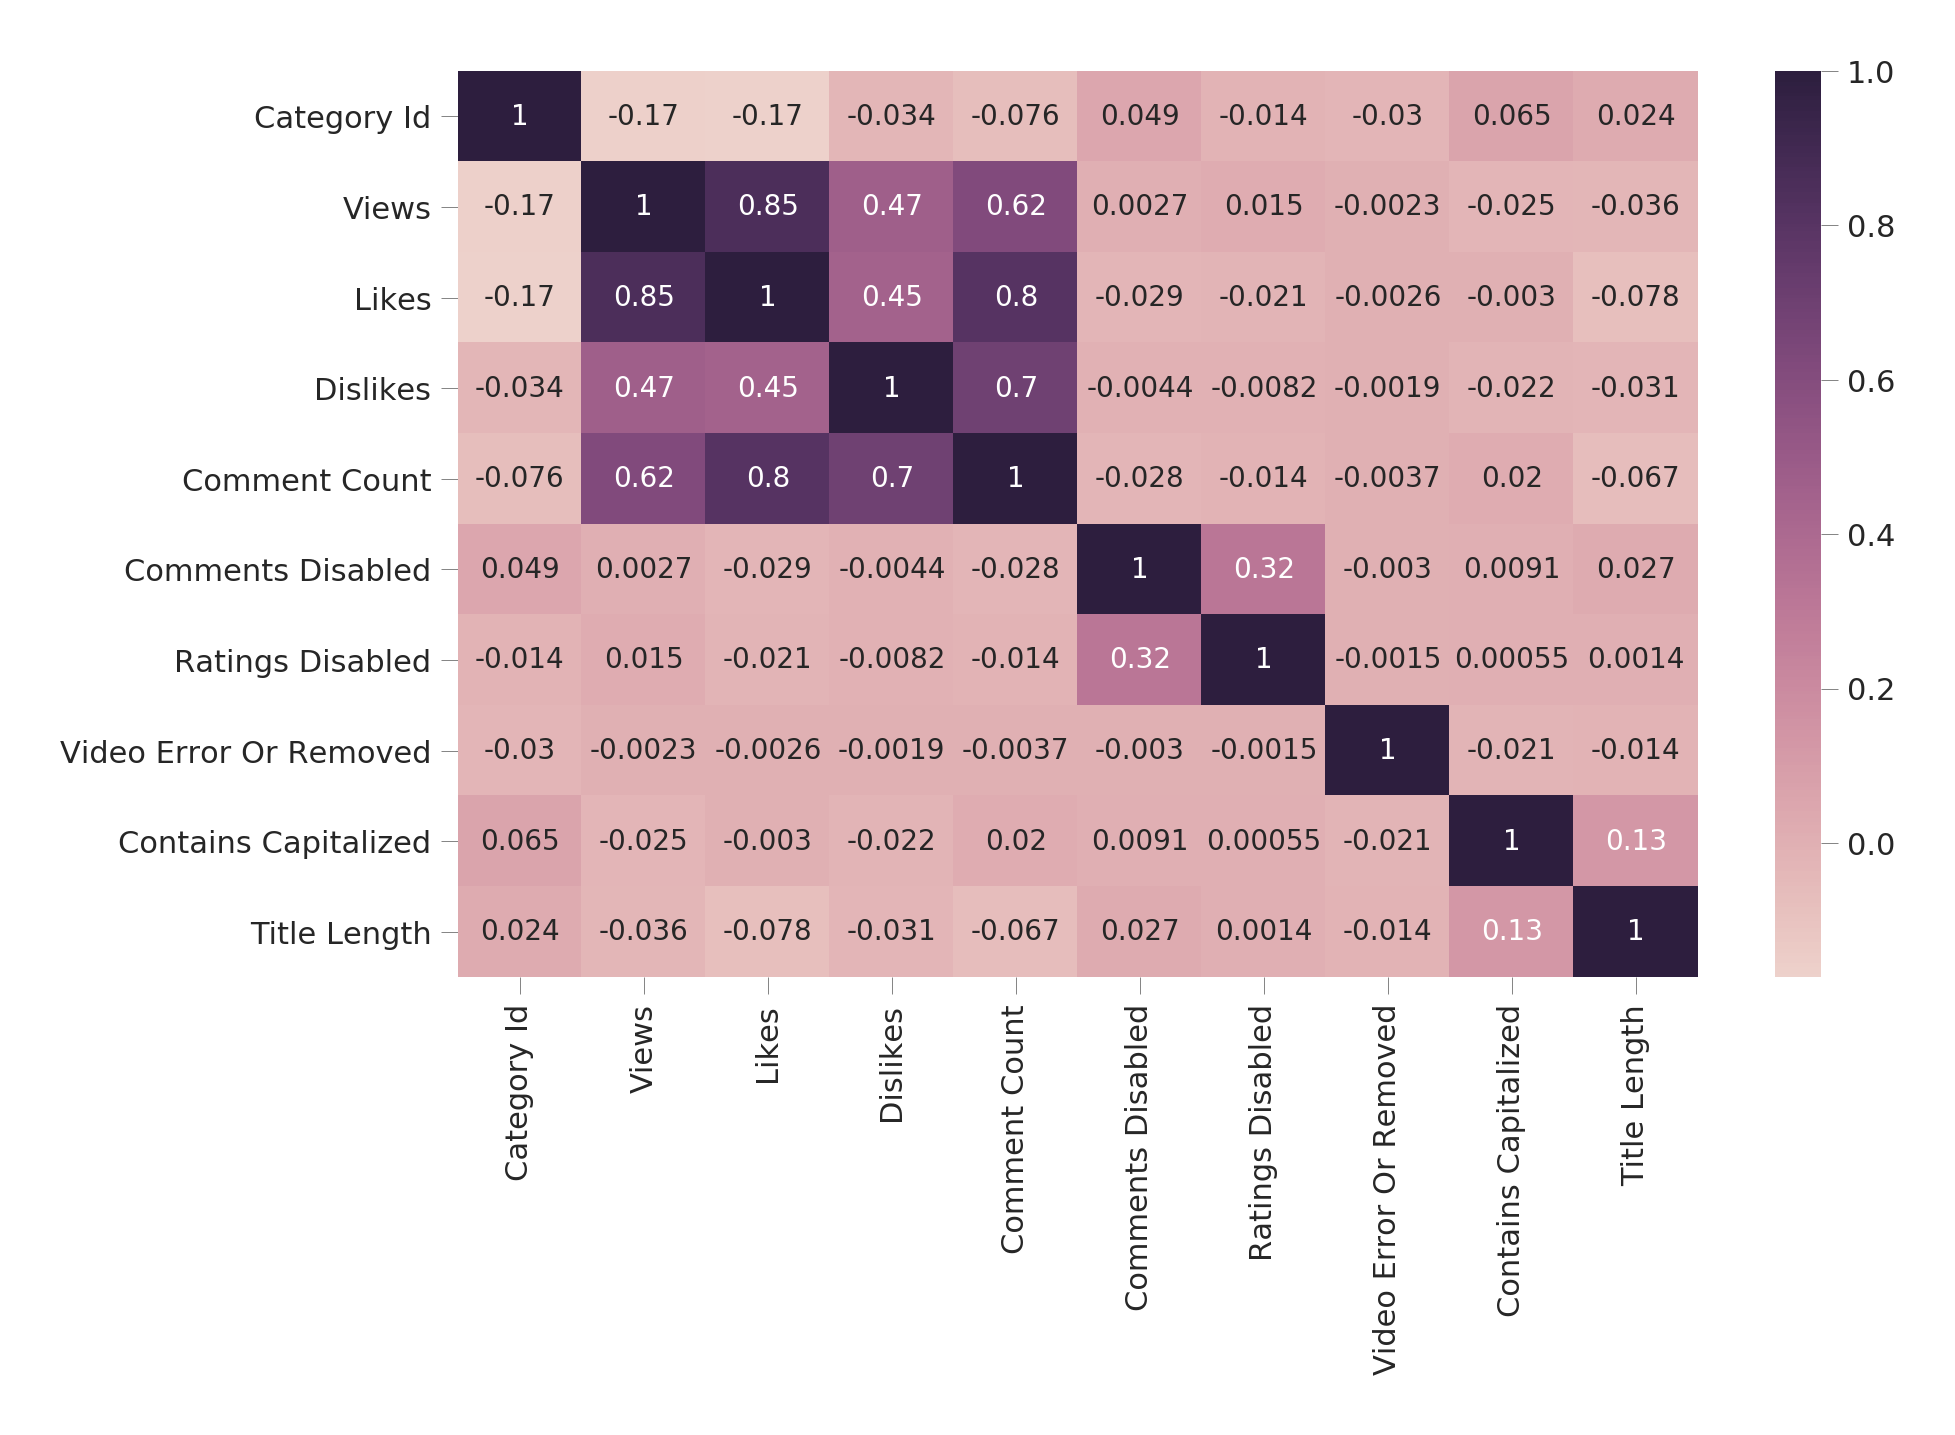

In [28]:
h_labels = [x.replace('_', ' ').title() for x in 
            list(df.select_dtypes(include=['number', 'bool']).columns.values)]

fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(df.corr(), annot=True, xticklabels=h_labels, yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

The correlation map and correlation table above say that views and likes are highly positively correlated. Let's verify that by plotting a scatter plot between views and likes to visualize the relationship between these variables

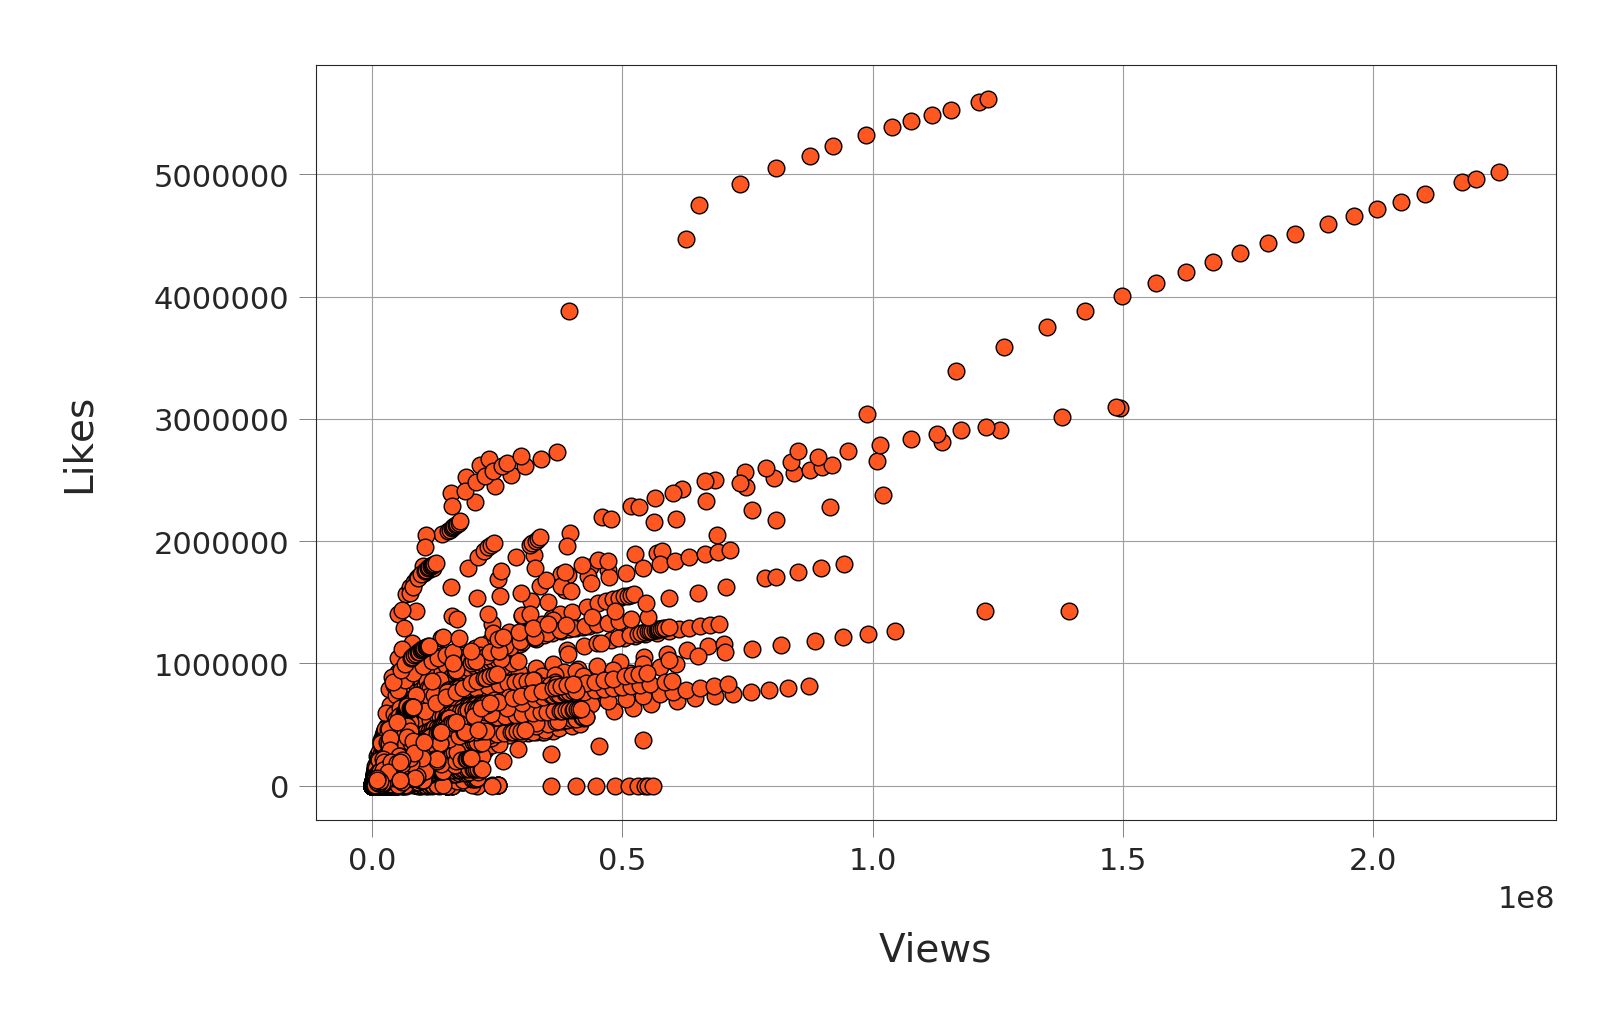

In [29]:
fig, ax = plt.subplots()
_ = plt.scatter(x=df['views'], y=df['likes'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel="Views", ylabel="Likes")

We see that views and likes are truly positively correlated: as one increases, the other increases too—mostly.

Another verification of the correlation matrix and map is the scatter plot we drew above between views and title length as it shows that there is no correlation between them.

## <a name="commti"></a>Most common words in video titles
Let's see if there are some words that are used significantly in trending video titles. We will display the `25` most common words in all trending video titles

In [30]:
title_words = list(df["title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(25)

[('-', 11452),
 ('|', 10663),
 ('The', 5762),
 ('the', 3610),
 ('a', 2566),
 ('to', 2343),
 ('of', 2338),
 ('in', 2176),
 ('A', 2122),
 ('&', 2024),
 ('I', 1940),
 ('and', 1917),
 ('Video)', 1901),
 ('Trailer', 1868),
 ('How', 1661),
 ('with', 1655),
 ('2018', 1613),
 ('(Official', 1594),
 ('Official', 1554),
 ('on', 1552),
 ('To', 1397),
 ('You', 1254),
 ('My', 1080),
 ('for', 1020),
 ('ft.', 1017)]

Ignoring words like "the" and "of", we can see that "-" and "|" symbols occured a lot in the `40949` trending video titles: `11452` times and `10663` times respectively. We notice also that words "Video", "Trailer", "How", and "2018" are common in trending video titles; each occured in 1613-1901 video titles.

Let's draw a word cloud for the titles of our trending videos, which is a way to visualize most common words in the titles; the more common the word is, the bigger its font size is

## <a name="chan"></a>Which channels have the largest number of trending videos?

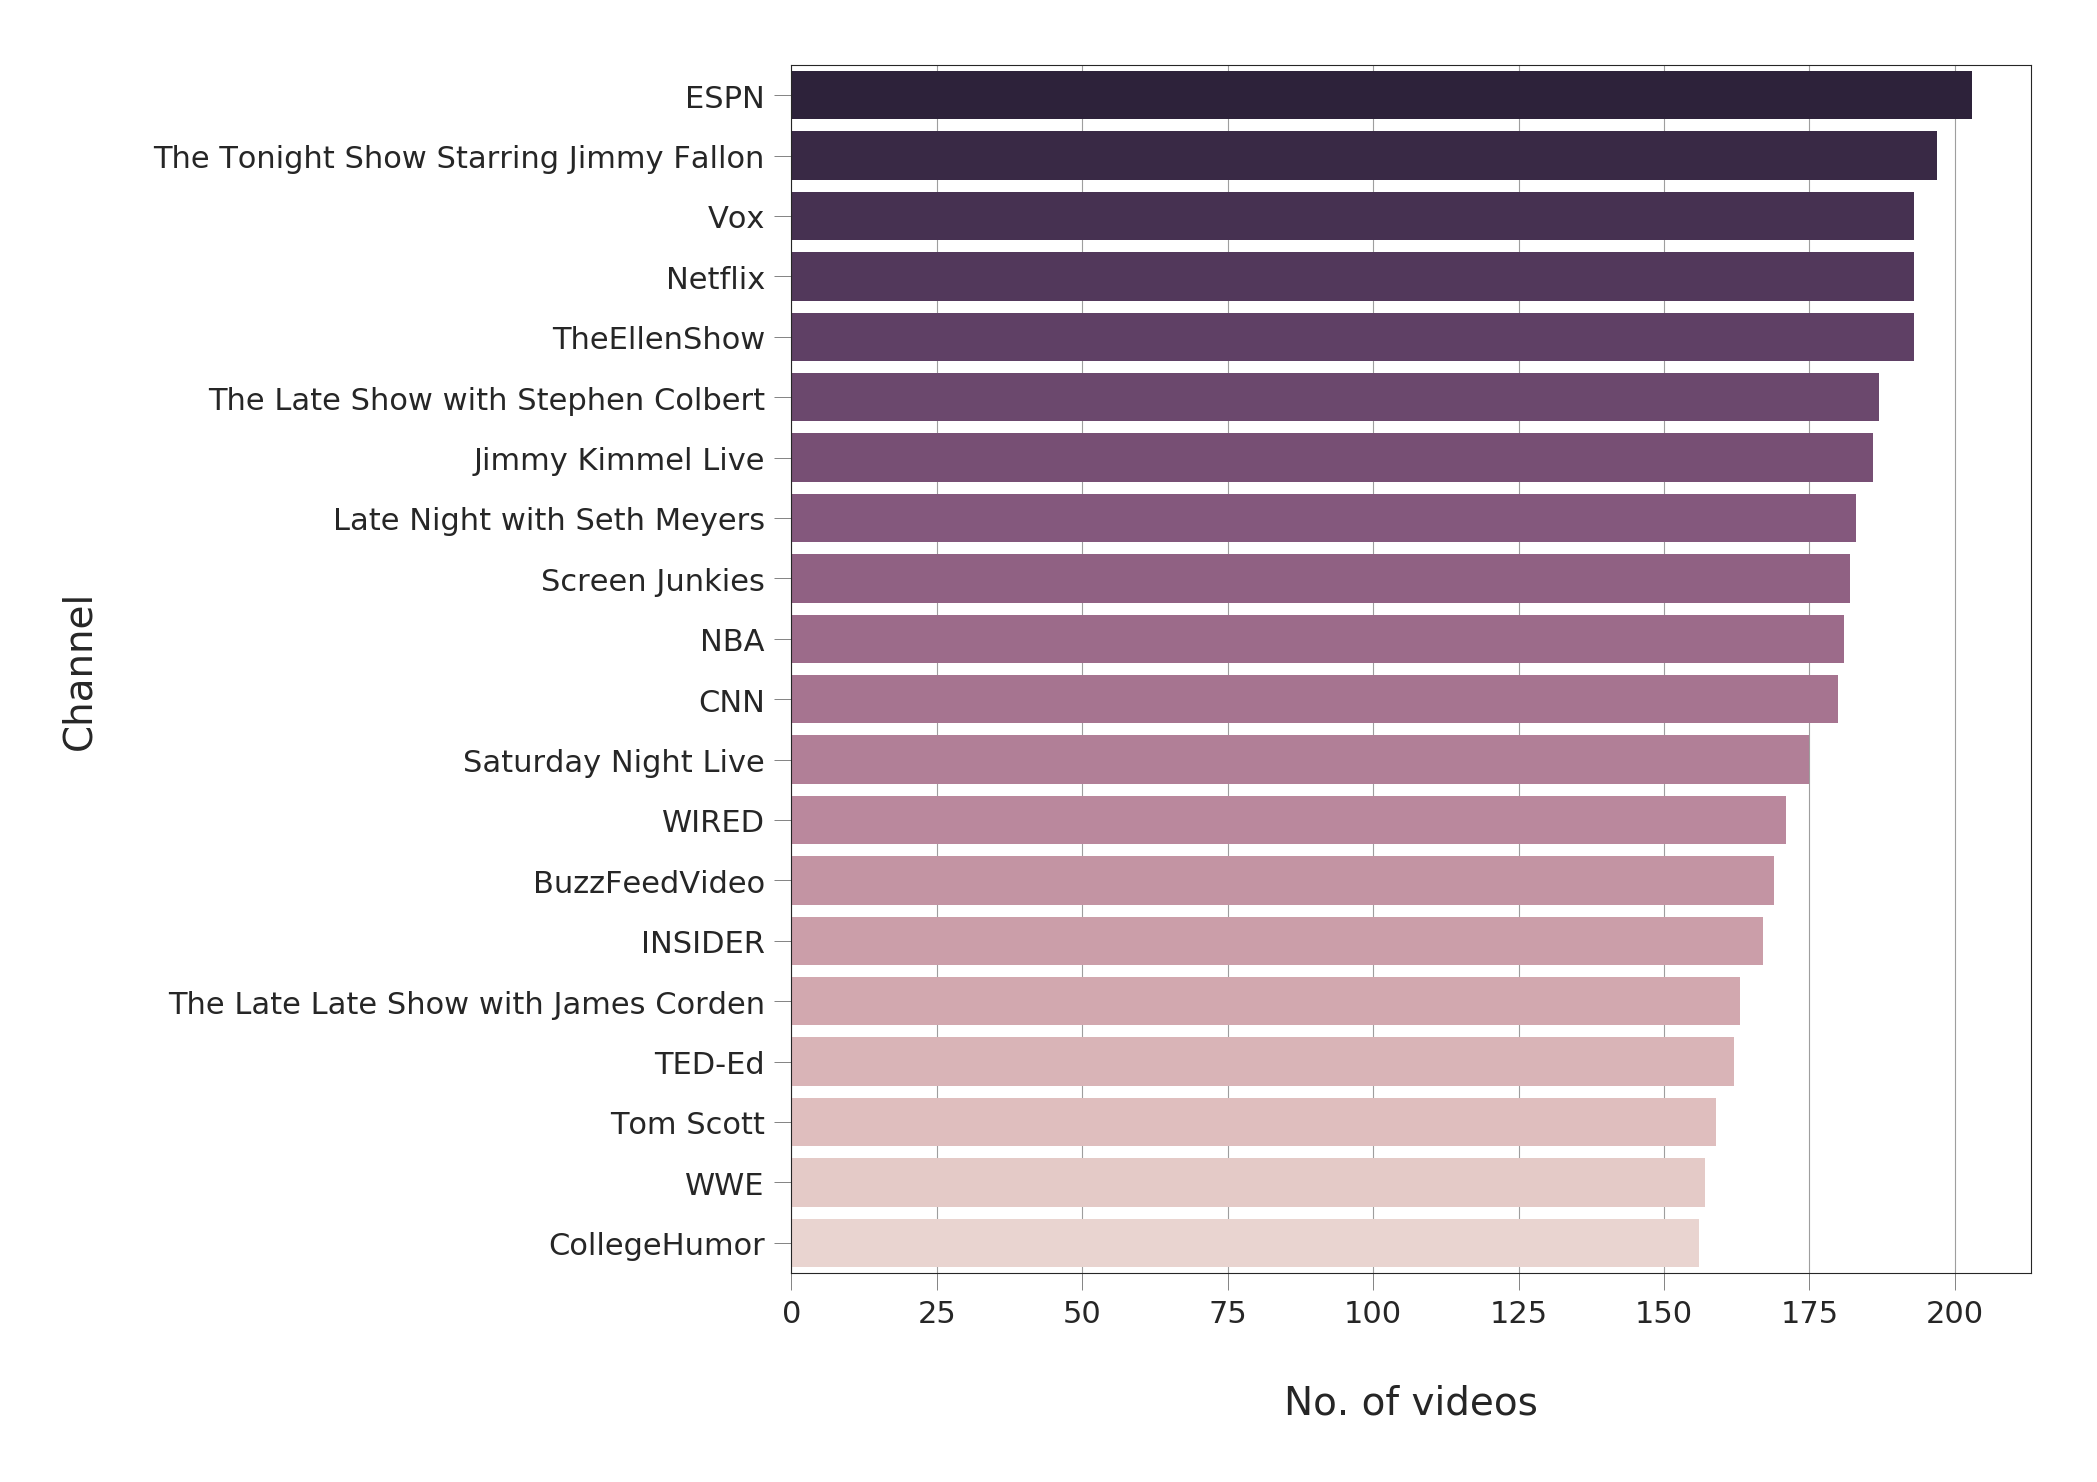

In [31]:
cdf = df.groupby("channel_title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8,8))
_ = sns.barplot(x="video_count", y="channel_title", data=cdf,
                palette=sns.cubehelix_palette(n_colors=20, reverse=True), ax=ax)
_ = ax.set(xlabel="No. of videos", ylabel="Channel")

## <a name="cat"></a>Which video category has the largest number of trending videos?
First, we will add a column that contains category names based on the values in `category_id` column. We will use a category JSON file provided with the dataset which contains information about each category.

In [32]:
with open("../input/US_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
df['category_name'] = df['category_id'].map(cat_dict)

Now we can see which category had the largest number of trending videos

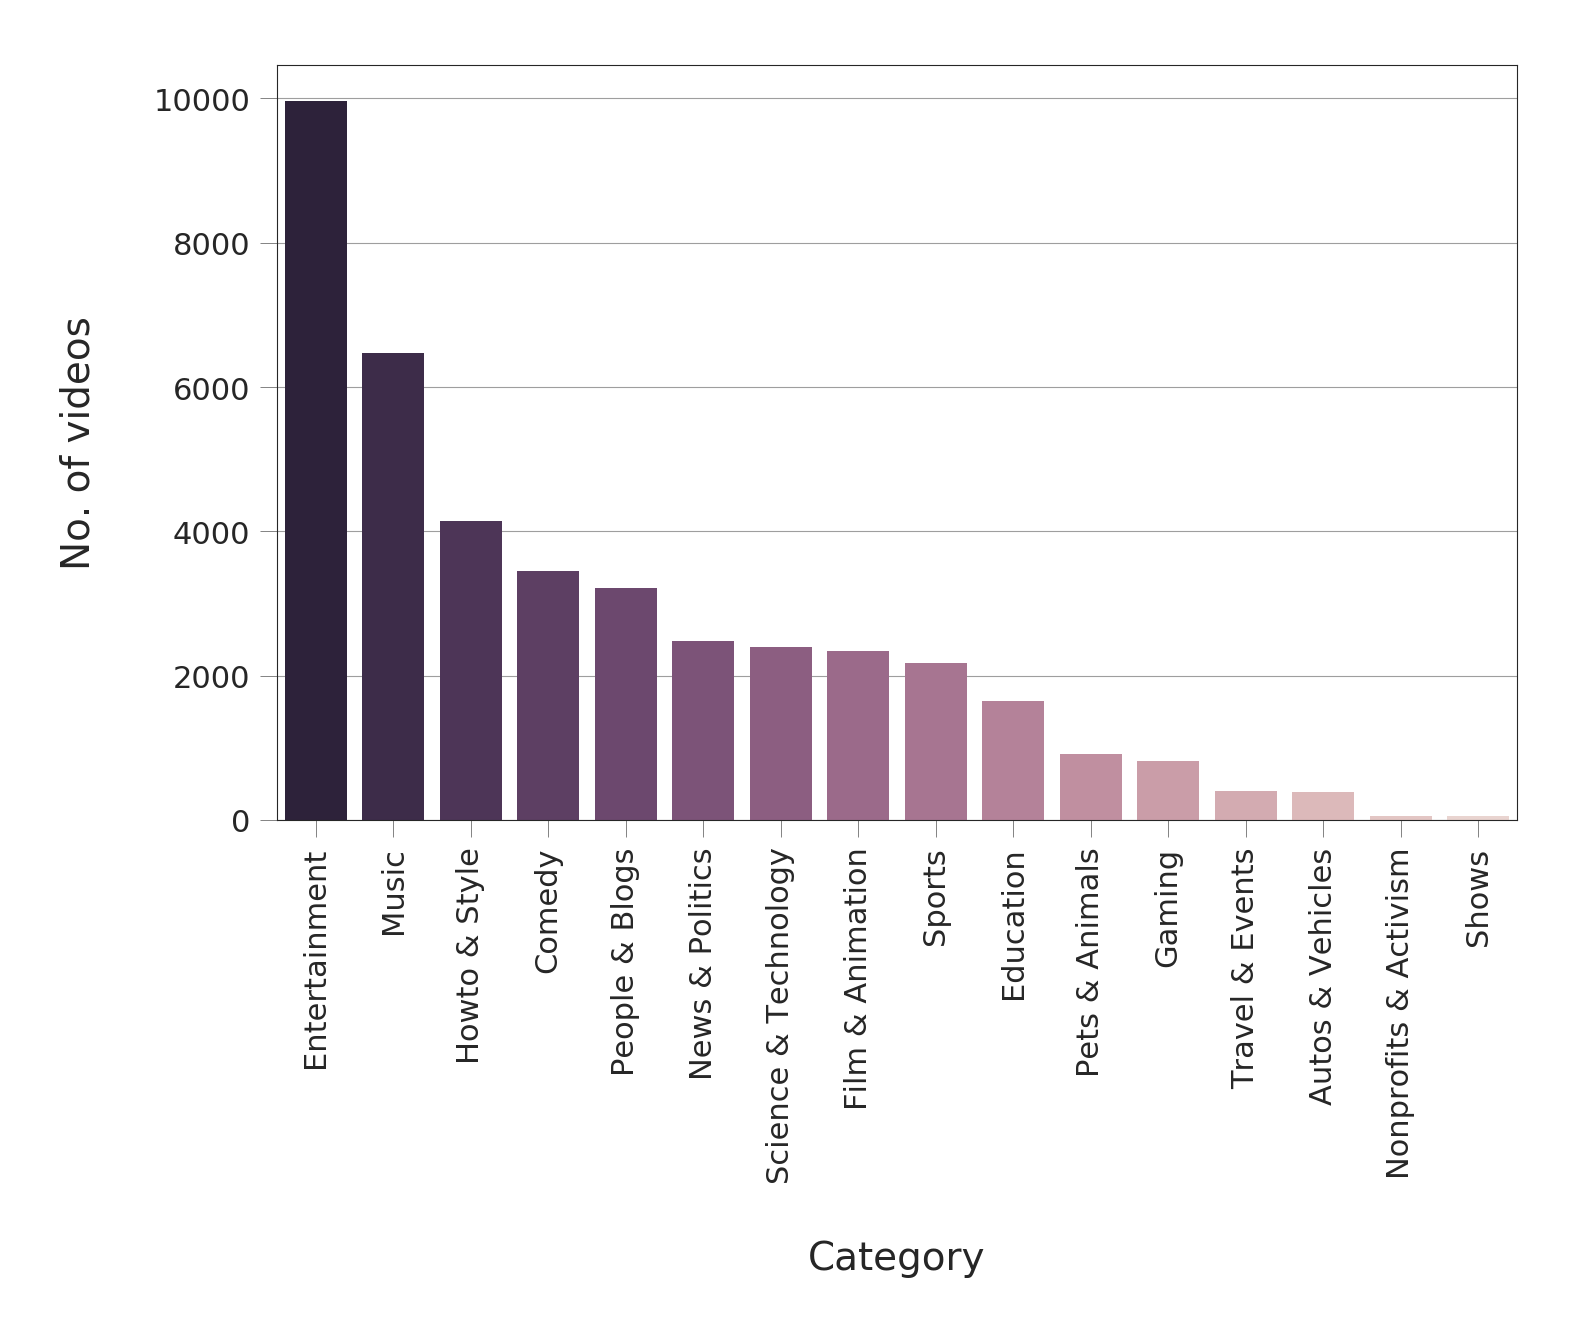

In [33]:
cdf = df["category_name"].value_counts().to_frame().reset_index()
cdf.rename(columns={"index": "category_name", "category_name": "No_of_videos"}, inplace=True)
fig, ax = plt.subplots()
_ = sns.barplot(x="category_name", y="No_of_videos", data=cdf, 
                palette=sns.cubehelix_palette(n_colors=16, reverse=True), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="Category", ylabel="No. of videos")

We see that the Entertainment category contains the largest number of trending videos among other categories: around `10,000` videos, followed by Music category with around `6,200` videos, followed by Howto & Style category with around `4,100` videos, and so on.

## <a name="pub"></a>Trending videos and their publishing time
An example value of the `publish_time` column in our dataset is `2017-11-13T17:13:01.000Z`. And according to information on this page: https://www.w3.org/TR/NOTE-datetime, this means that the date of publishing the video is `2017-11-13` and the time is `17:13:01` in Coordinated Universal Time (UTC) time zone.

Let's add two columns to represent the date and hour of publishing each video, then delete the original `publish_time` column because we will not need it anymore

In [34]:
df["publishing_day"] = df["publish_time"].apply(
    lambda x: datetime.datetime.strptime(x[:10], "%Y-%m-%d").date().strftime('%a'))
df["publishing_hour"] = df["publish_time"].apply(lambda x: x[11:13])
df.drop(labels='publish_time', axis=1, inplace=True)

Now we can see which days of the week had the largest numbers of trending videos

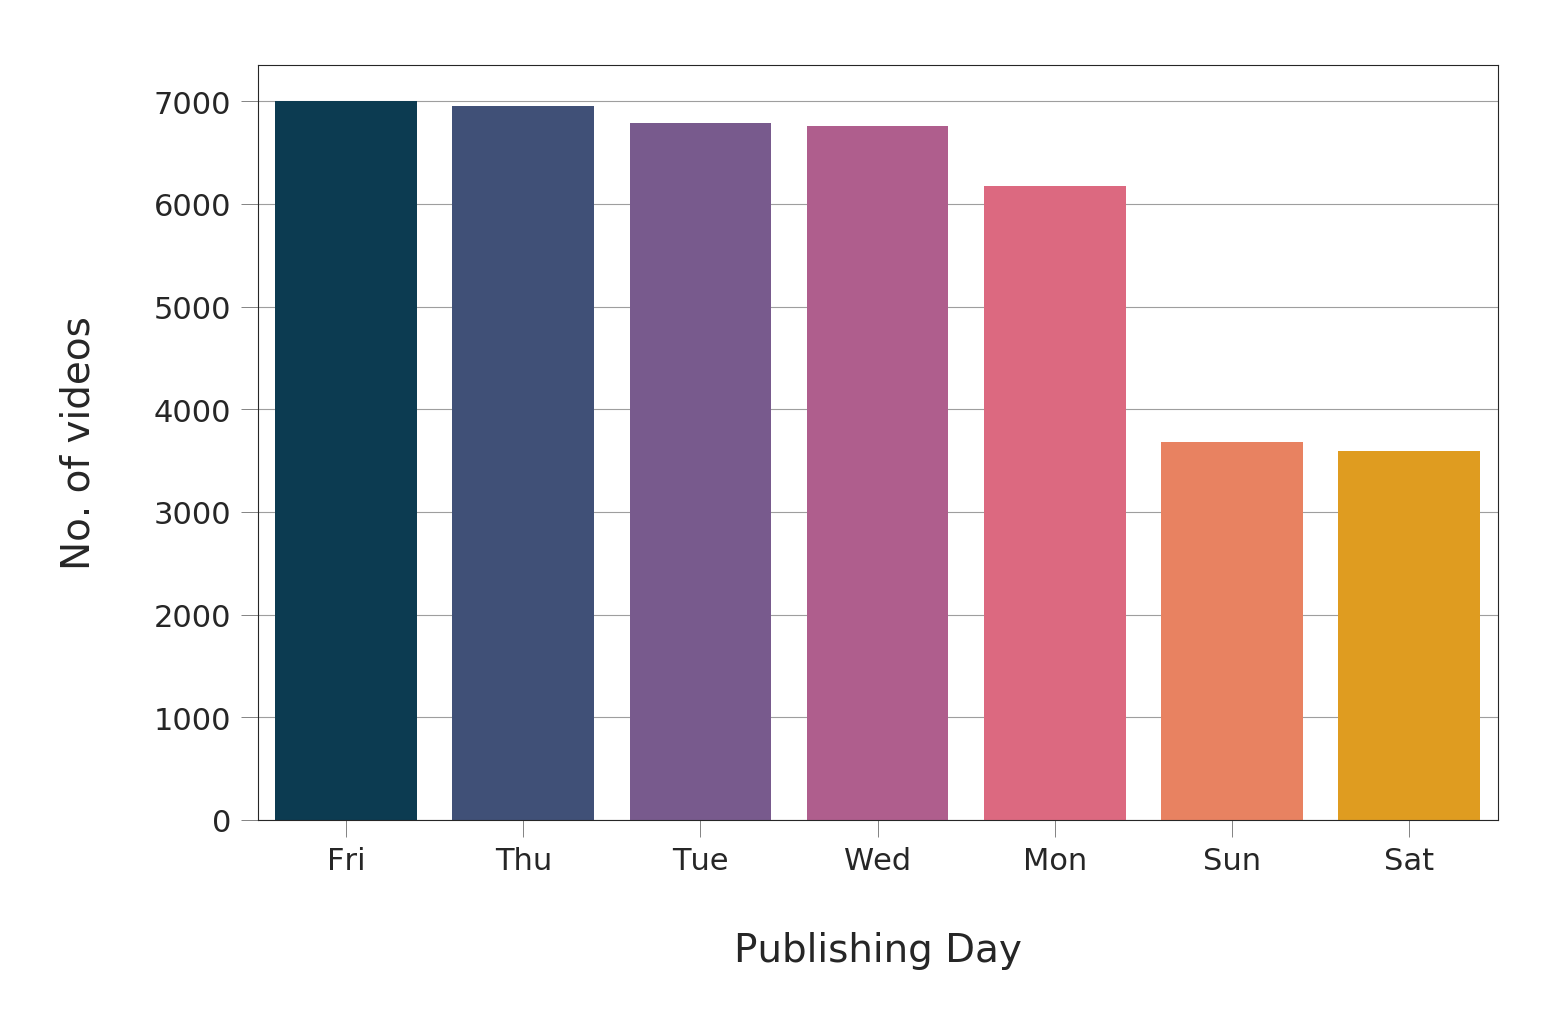

In [35]:
cdf = df["publishing_day"].value_counts()\
        .to_frame().reset_index().rename(columns={"index": "publishing_day", "publishing_day": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_day", y="No_of_videos", data=cdf, 
                palette=sns.color_palette(['#003f5c', '#374c80', '#7a5195', 
                                           '#bc5090', '#ef5675', '#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Publishing Day", ylabel="No. of videos")

We can see that the number of trending videos published on Sunday and Saturday are noticeably less than the number of trending videos published on other days of the week.

Now let's use `publishing_hour` column to see which publishing hours had the largest number of trending videos

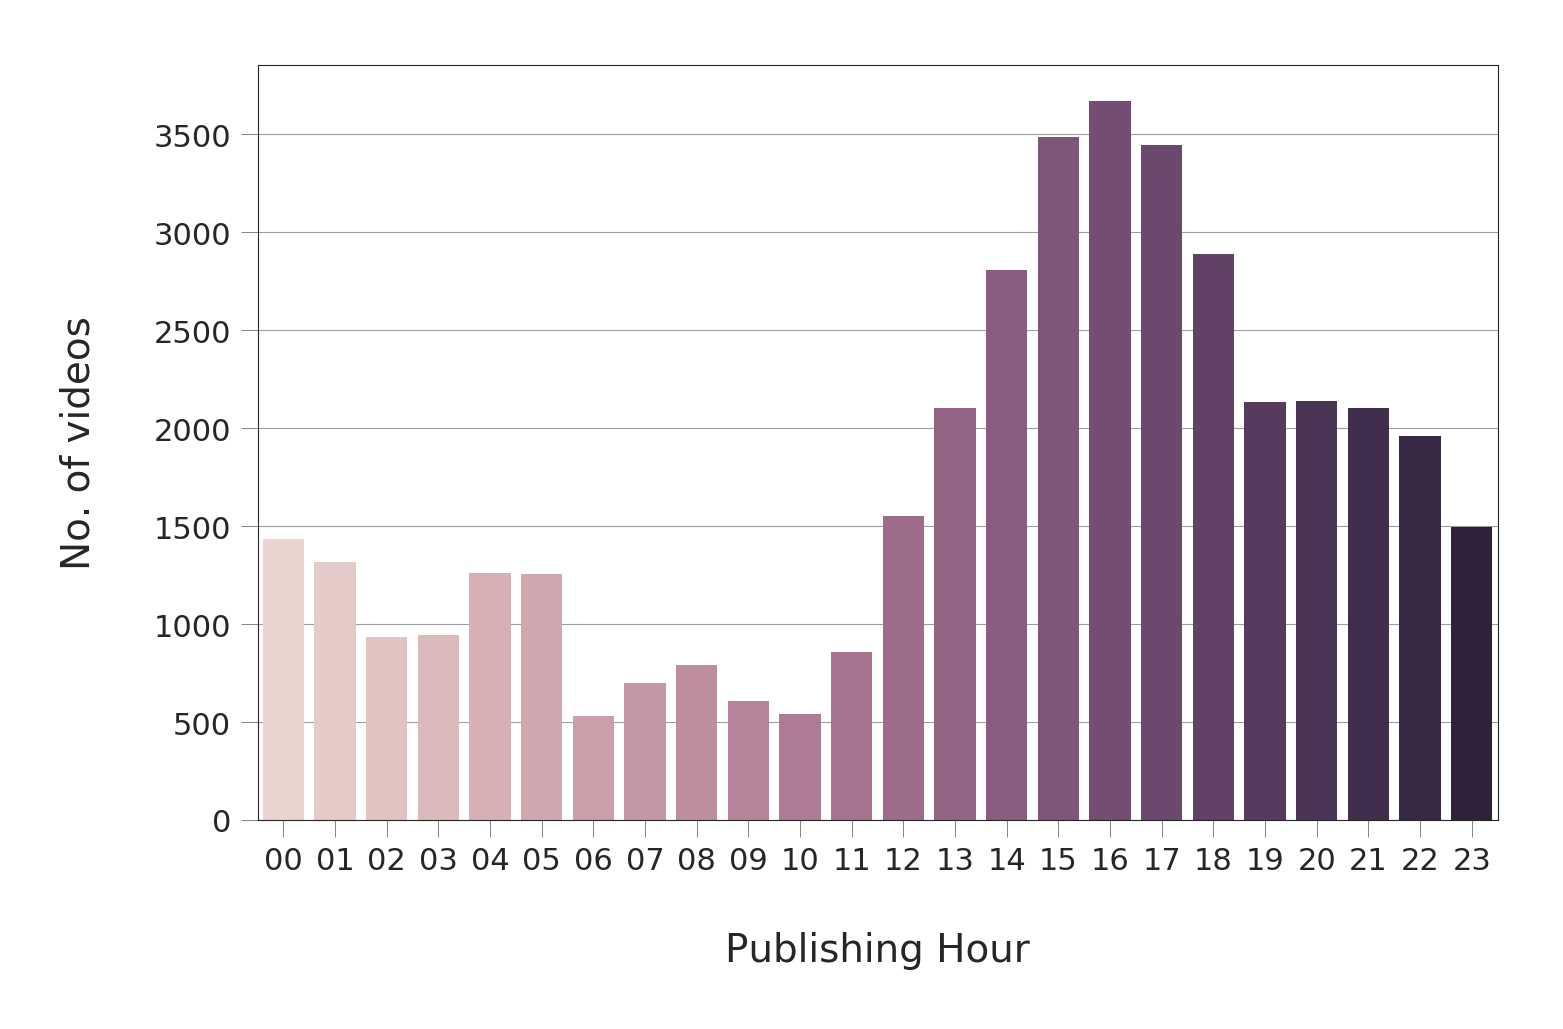

In [36]:
cdf = df["publishing_hour"].value_counts().to_frame().reset_index()\
        .rename(columns={"index": "publishing_hour", "publishing_hour": "No_of_videos"})
fig, ax = plt.subplots()
_ = sns.barplot(x="publishing_hour", y="No_of_videos", data=cdf, 
                palette=sns.cubehelix_palette(n_colors=24), ax=ax)
_ = ax.set(xlabel="Publishing Hour", ylabel="No. of videos")

We can see that the period between 2PM and 7PM, peaking between 4PM and 5PM, had the largest number of trending videos. We notice also that the period between 12AM and 1PM has the smallest number of trending videos. But why is that? Is it because people publish a lot more videos between 2PM and 7PM? Is it because how YouTube algorithm chooses trending videos?

## <a name="err"></a>How many trending videos have an error?
To see how many trending videos got removed or had some error, we can use `video_error_or_removed` column in the dataset

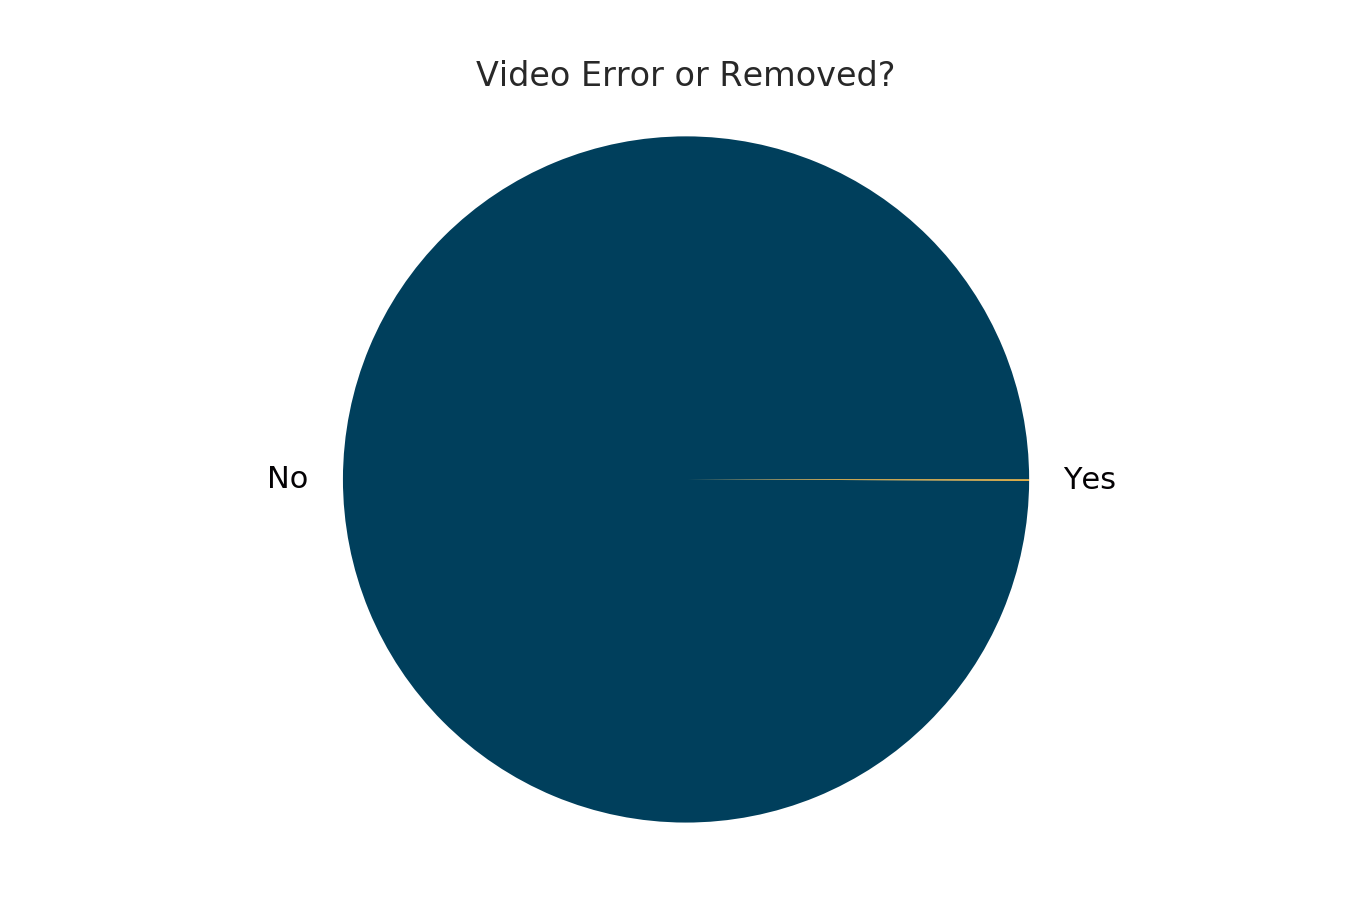

In [37]:
value_counts = df["video_error_or_removed"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
        colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'})
_ = ax.axis('equal')
_ = ax.set_title('Video Error or Removed?')

In [38]:
df["video_error_or_removed"].value_counts()

False    40926
True        23
Name: video_error_or_removed, dtype: int64

We can see that out of videos that appeared on trending list (`40949` videos), there is a tiny portion (`23` videos) with errors.

## <a name="commdis"></a>How many trending videos have their commets disabled?
To know that, we use `comments_disabled` column

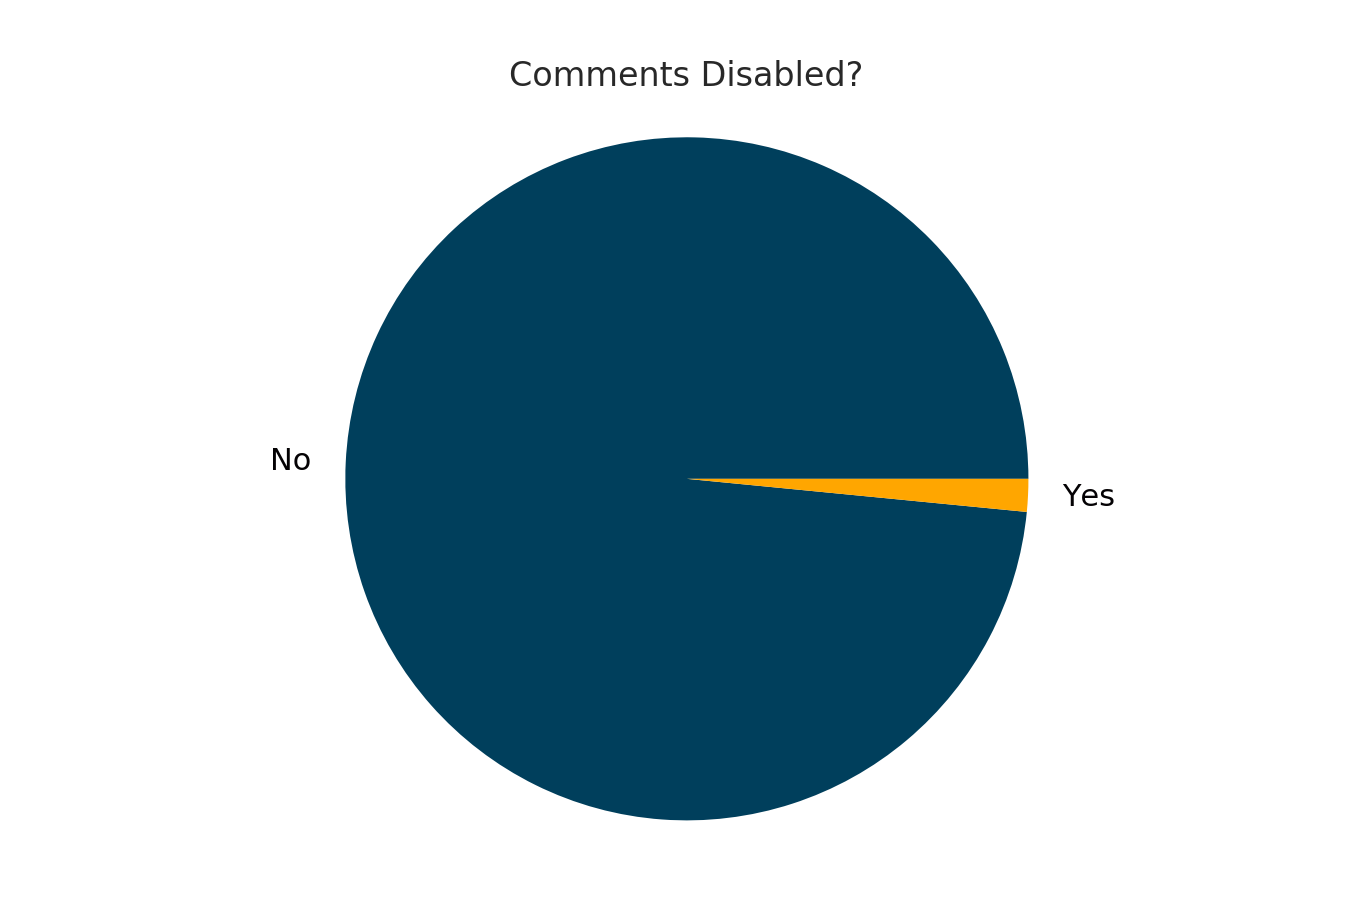

In [39]:
value_counts = df["comments_disabled"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie(x=[value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'})
_ = ax.axis('equal')
_ = ax.set_title('Comments Disabled?')

In [40]:
df["comments_disabled"].value_counts(normalize=True)

False   0.98
True    0.02
Name: comments_disabled, dtype: float64

We see that only `2%` of trending videos prevented users from commenting.

## <a name="ratdis"></a>How many trending videos have their ratings disabled?
To know that, we use `ratings_disabled` column

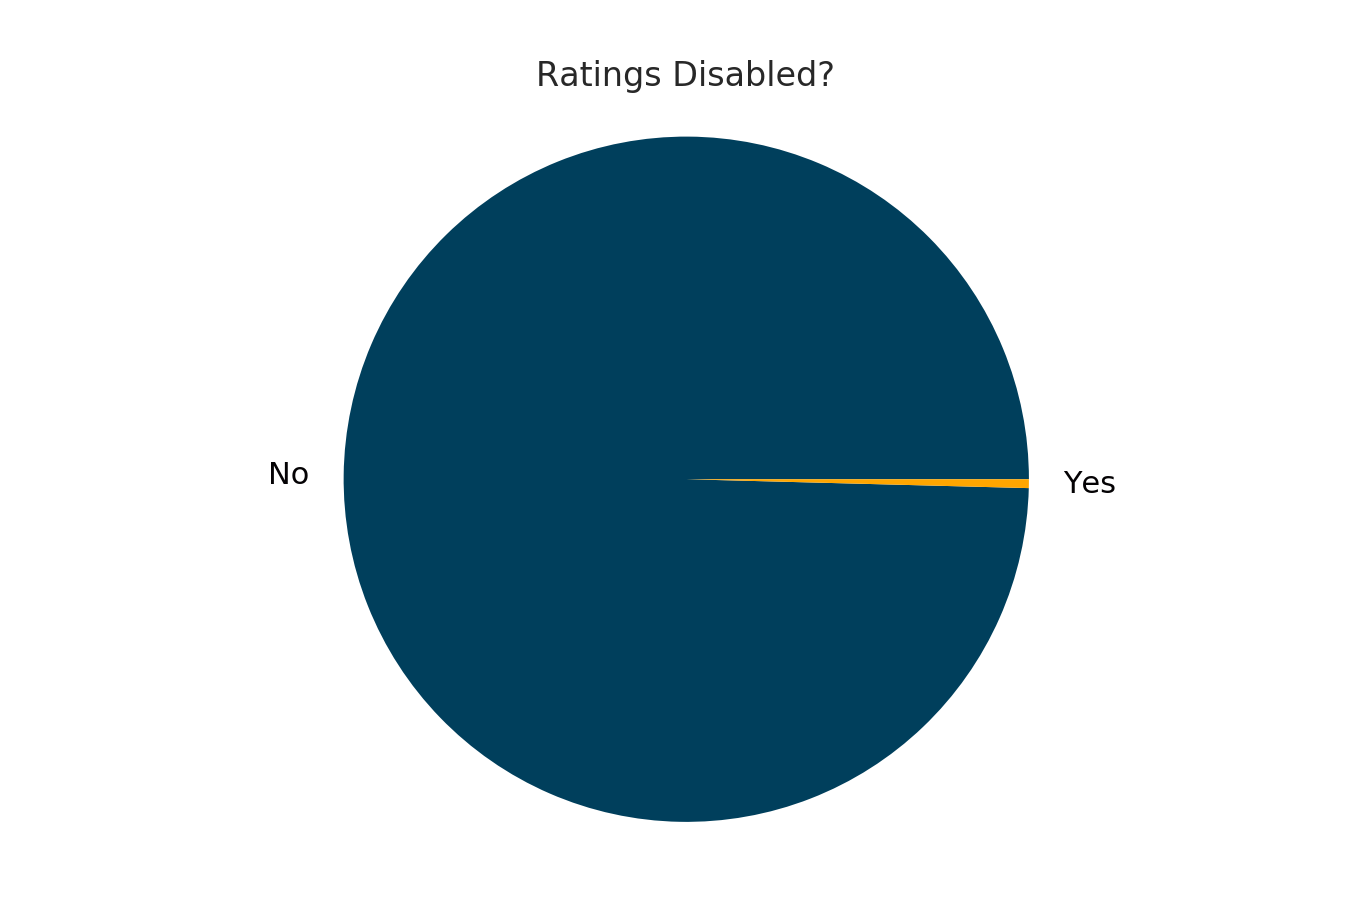

In [41]:
value_counts = df["ratings_disabled"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
            colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'})
_ = ax.axis('equal')
_ = ax.set_title('Ratings Disabled?')

In [42]:
df["ratings_disabled"].value_counts()

False    40780
True       169
Name: ratings_disabled, dtype: int64

We see that only `169` trending videos out of `40949` prevented users from commenting.

## <a name="commratdis"></a>How many videos have both comments and ratings disabled?

In [43]:
len(df[(df["comments_disabled"] == True) & (df["ratings_disabled"] == True)].index)

106

So there are just `106` trending videos that have both comments and ratings disabled

# Conclusion


Here are the some of the results we extracted from the analysis:
1. We analyzed a dataset that contains information about YouTube trending videos for 205 days. The dataset was collected in 2017 and 2018. It contains **`40949`** video entry.
2. `71%` of trending videos have less than `1.5` million views, and **`91%`** have less than **`5`** million views.
3. `68%` of trending videos have less than `40,000` likes, and **`84%`** have less than **`100,000`** likes.
4. `67%` of trending videos have less than `4,000` comments, and **`93%`** have less than **`25,000`** comments.
5. Some videos may appear on the trending videos list on more than one day. Our dataset contains `40494` entries but not for `40494` unique videos but for `6351`unique videos.
6. Trending videos that have **`100,000,000`** views and more  have title length between `33` and `55` characters approximately.
7. The delimiters `-` and `|` were common in trending video titles.
7. The words 'Official', 'Video', 'Trailer', 'How', and '2018' were common also in trending video titles.
8. There is a strong positive correlation between the number of views and the number of likes of trending videos: As one of them increases, the other increases, and vice versa.
9. There is a strong positive correlation also between the number of likes and the number of comments, and a slightly weaker one between the number of dislikes and the number of comments.
10. The category that has the largest number of trending videos is 'Entertainment' with `9,964` videos, followed by 'Music' category with `6,472` videos, followed by 'Howto & Style' category with `4146` videos.
11. On the opposite side, the category that has the smallest number of trending videos is 'Shows' with `57` videos, followed by 'Nonprofits & Activisim' with `57` videos, followed by 'Autos & Vehicles' with `384` videos.